# Show contributions to ComBind Score in a Heiracrchical Fashion

In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import sys
sys.path.append('../')
from containers import Ligand, Protein
from shared_paths import shared_paths
from score.scores import ScoreContainer
from score.prob_opt import PredictStructs
%matplotlib inline

In [2]:
def load(prot, stats, scores, fname, struct):
    root = '{}/{}/scores/{}'.format(shared_paths['data'], prot, scores)
    stats_root = '{}/{}/scores/{}'.format(shared_paths['data'], prot, stats)
    sc = ScoreContainer(root, stats_root, prot, struct)
    cluster = sc.read_results(fname)
    glide_cluster = {ligand: 0 for ligand in cluster}
    best_cluster = {}
    for name, ligand in sc.ps.ligands.items():
        best_rmsd, best_pose = float('inf'), -1
        for i, pose in enumerate(ligand.poses[:100]):
            if pose.rmsd and pose.rmsd < best_rmsd:
                best_pose = i
                best_rmsd = pose.rmsd
            if pose.rmsd and pose.rmsd < 2.0:
                best_cluster[name] = i
                break
        if name not in best_cluster:
            best_cluster[name] = best_pose
    
    return cluster, glide_cluster, best_cluster, sc

def plot(best=True):
    f = plt.figure(figsize=(20, 5))

    gs = GridSpec(2, 4, figure=f, height_ratios=[15, 1])

    crystal_ax = f.add_subplot(gs[0, 0])
    best_ax = f.add_subplot(gs[0, 1])
    combind_ax = f.add_subplot(gs[0, 2])
    glide_ax = f.add_subplot(gs[0, 3])

    best_corr = f.add_subplot(gs[1, 1])
    combind_corr = f.add_subplot(gs[1, 2])
    glide_corr = f.add_subplot(gs[1, 3])

    lig_order =list(cluster.keys())   
    interactions = sc.ps.interactions([cluster, glide_cluster, best_cluster], 'hbond')

    if best:
        best_poses = sc.ps.get_poses(best_cluster)
        lig_order = sorted(lig_order, key=lambda x: best_poses[x].rmsd)
        
        # Add RMSDs.
        combind_poses = sc.ps.get_poses(cluster)
        combind_rmsds = np.array([combind_poses[ligand].rmsd for ligand in lig_order]).reshape(1, -1)
        combind_corr.imshow(-combind_rmsds, aspect = 'auto', cmap='binary', vmin = -3, vmax = 0)
        glide_poses = sc.ps.get_poses(glide_cluster)
        glide_rmsds = np.array([glide_poses[ligand].rmsd for ligand in lig_order]).reshape(1, -1)
        glide_corr.imshow(-glide_rmsds, aspect = 'auto', cmap='binary', vmin = -3, vmax = 0)
    
        best_poses = sc.ps.get_poses(best_cluster)
        best_rmsds = np.array([best_poses[ligand].rmsd for ligand in lig_order]).reshape(1, -1)
        best_corr.imshow(-best_rmsds, aspect = 'auto', cmap='binary', vmin = -3, vmax = 0)

        # Annotate
        def annotate(idx, c):
            idx = idx.reshape((-1))
            idx = 2*(np.array(range(len(idx)))[idx])
            for ax in [crystal_ax, best_ax, combind_ax, glide_ax]:
                for i in idx:
                    ax.axvline(i, c = c)
        # Nothing: Correct in all or wrong in all.
        # Green: ComBind improves
        idx = (combind_rmsds <= 2) & (glide_rmsds > 2)
        annotate(idx, 'g')
        # Red: ComBind degrades
        idx = (combind_rmsds > 2) & (glide_rmsds <= 2)
        annotate(idx, 'r')
        # Blue: ComBind could improve, but doesn't.
        idx = (best_rmsds < 2) & (combind_rmsds > 2) & (glide_rmsds > 2)
        annotate(idx, 'b')
    
    # Add interactions.
    sc.ps.gel_plot_individual(cluster, 'hbond', lig_order, interactions=interactions, ax=combind_ax, pretty=False)
    sc.ps.gel_plot_individual(glide_cluster, 'hbond', lig_order, interactions=interactions, ax=glide_ax, pretty=False)
    
    if best:
        crystal_ps.gel_plot_individual(crystal_cluster, 'hbond', lig_order, interactions=interactions, ax=crystal_ax, pretty=False)
        sc.ps.gel_plot_individual(best_cluster, 'hbond', lig_order, interactions=interactions, ax=best_ax, pretty=False)
    else:
        crystal_ax.imshow(np.zeros((2*len(interactions), 2*len(cluster))), aspect = 'auto')
        best_ax.imshow(np.zeros((2*len(interactions), 2*len(cluster))), aspect = 'auto')
        #crystal_ax.set(adjustable='box', aspect='equal')
        #best_ax.set(adjustable='box', aspect='equal')

    # Titles and axes.
    crystal_ax.set_title('Crystal', size=16)
    best_ax.set_title('Best', size=16)
    combind_ax.set_title('ComBind', size=16)
    glide_ax.set_title('Glide', size=16)

    for ax in [best_corr, combind_corr, glide_corr, best_ax, combind_ax, glide_ax]:
        ax.set_yticks([])
        ax.set_xticks([])

    crystal_ax.set_xticks(range(0, len(lig_order)*2, 2))
    crystal_ax.set_xticklabels(lig_order, rotation = 'vertical', fontsize=14)

    crystal_ax.set_yticks(range(0, len(interactions)*2, 2))
    crystal_ax.set_yticklabels([sc.ps._format_int(interaction) for interaction in interactions], fontsize=14)

    plt.show()

B2AR
results B2AR/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, B2AR, 2RH1, confgen_es4


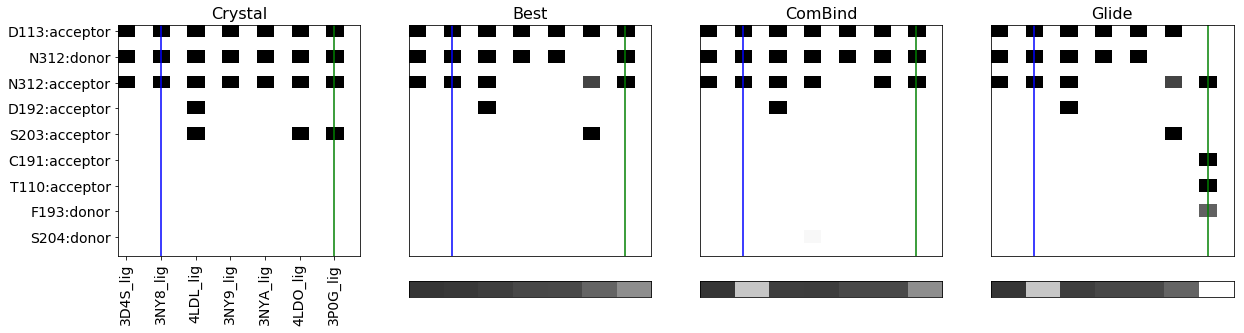

results B2AR/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/3NY9_lig-to-2RH1.sc, B2AR, 2RH1, confgen_es4


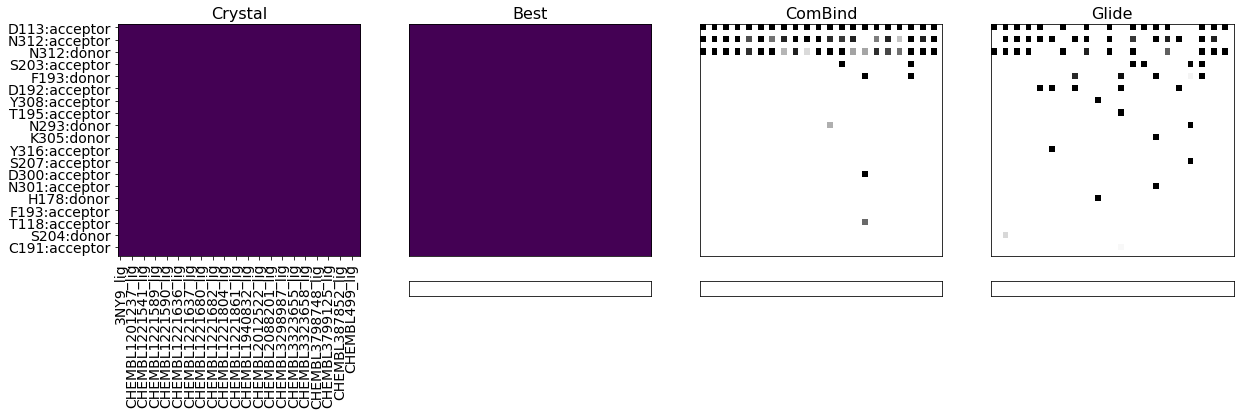

B1AR
results B1AR/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, B1AR, 2VT4, confgen_es4


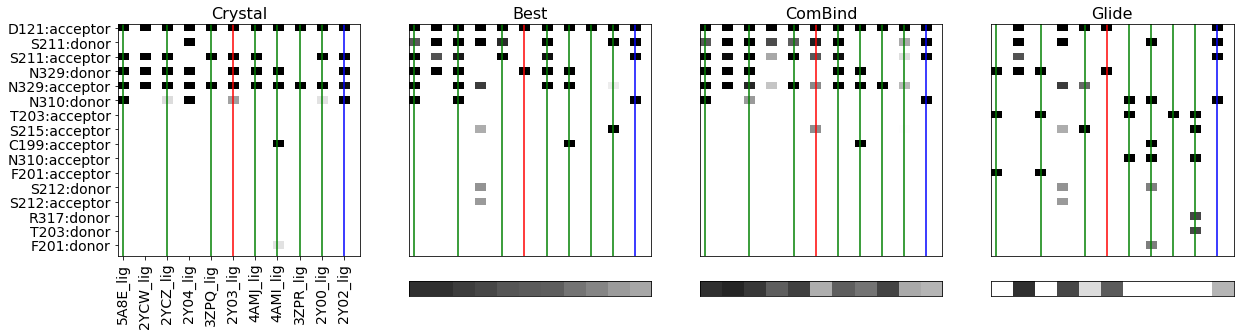

results B1AR/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/2Y02_lig-to-2VT4.sc, B1AR, 2VT4, confgen_es4


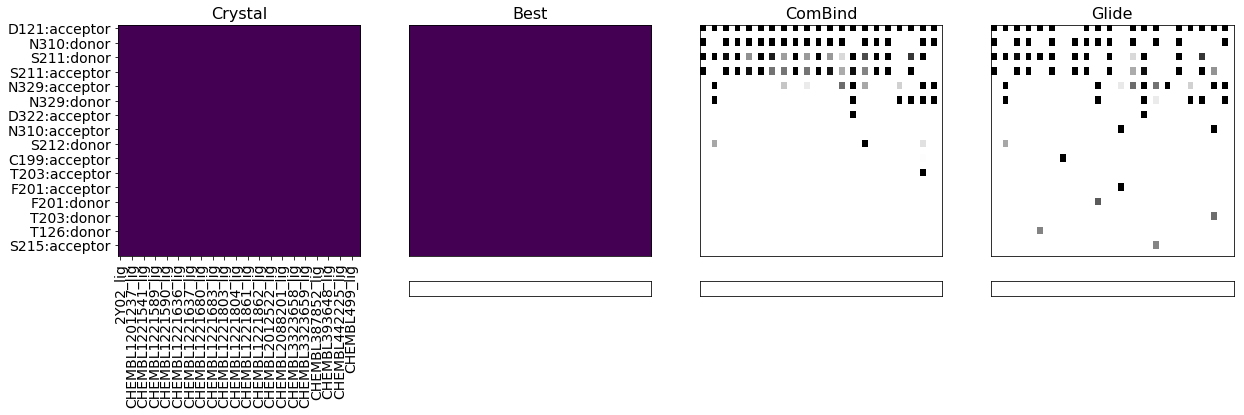

DAT
results DAT/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, DAT, 4M48, confgen_es4


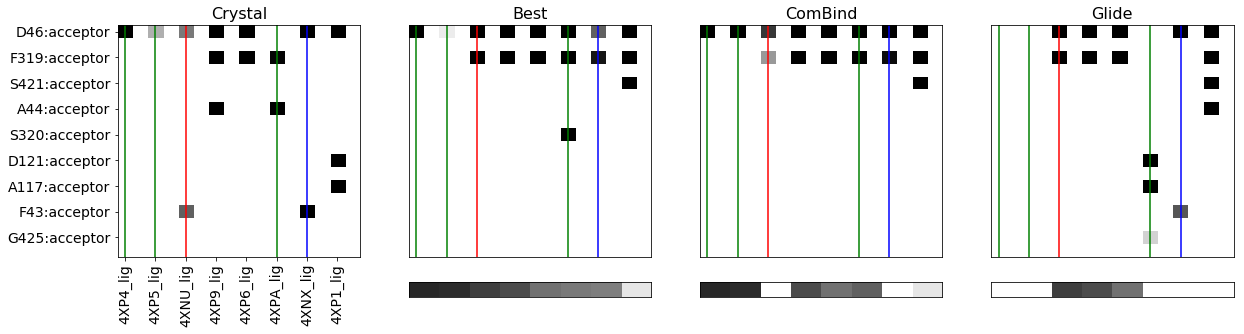

results DAT/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/4XNX_lig-to-4M48.sc, DAT, 4M48, confgen_es4


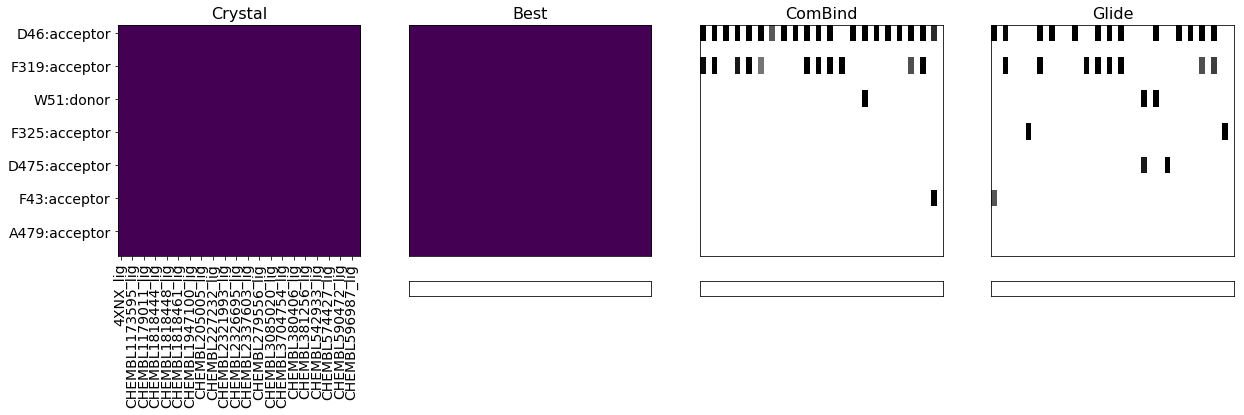

PLAU
results PLAU/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, PLAU, 1C5X, confgen_es4


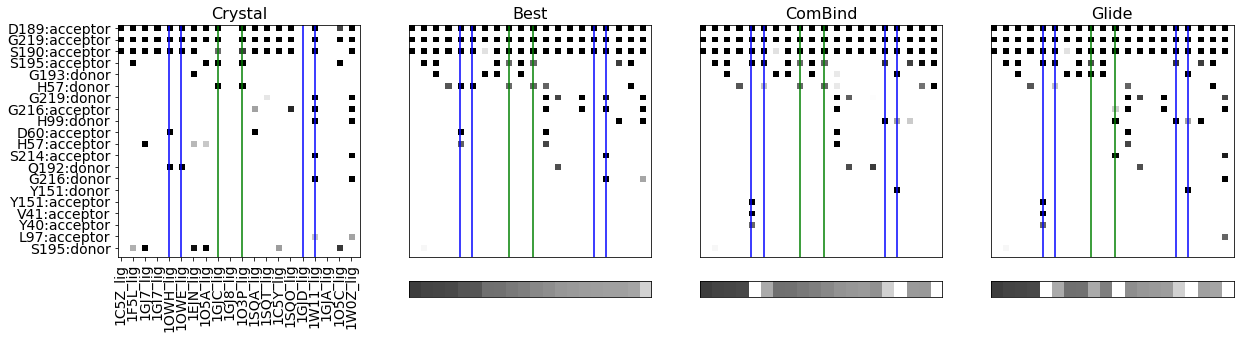

results PLAU/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/1EJN_lig-to-1C5X.sc, PLAU, 1C5X, confgen_es4


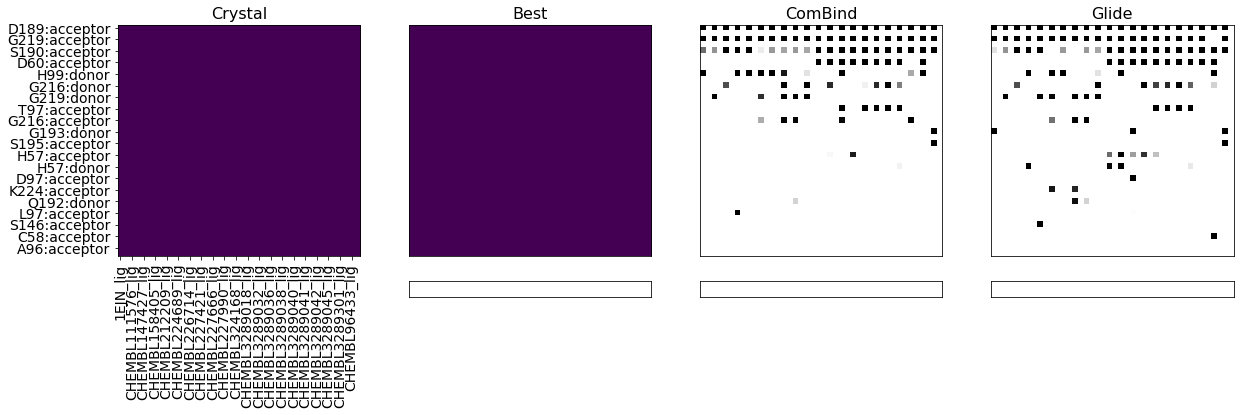

PTPN1
results PTPN1/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, PTPN1, 1BZC, confgen_es4


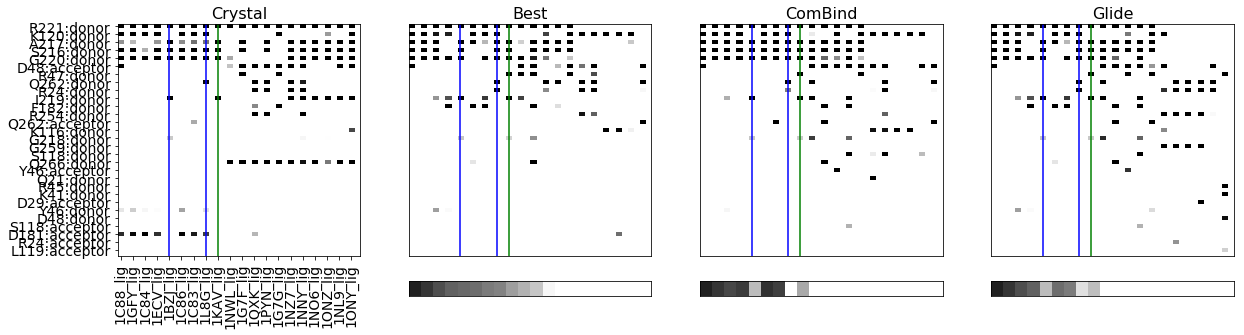

results PTPN1/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/1QXK_lig-to-1BZC.sc, PTPN1, 1BZC, confgen_es4


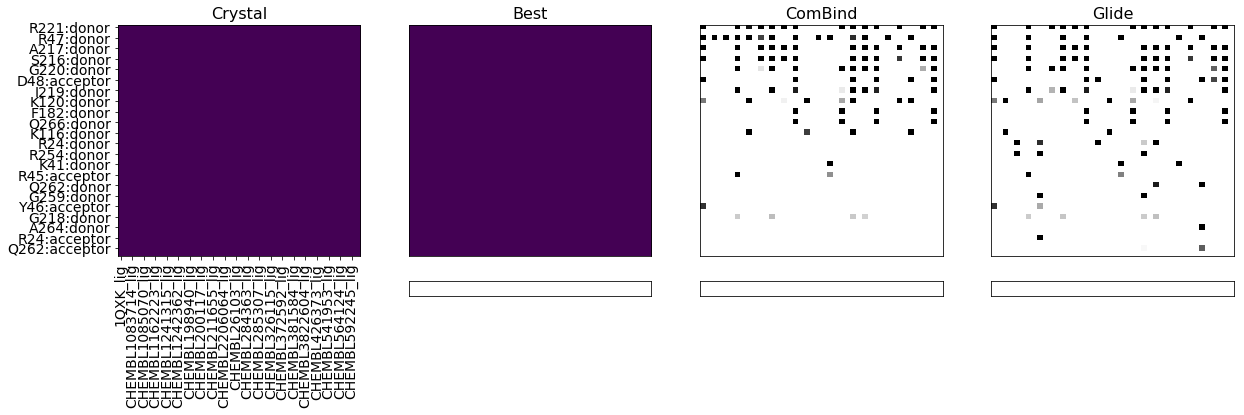

BACE1
results BACE1/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, BACE1, 1FKN, confgen_es4
too many values to unpack (expected 3)
/Users/jpaggi/Downloads/combind_data/bpp_data/BACE1/ifp/ifp5/3KMY_struct.fp fp not found


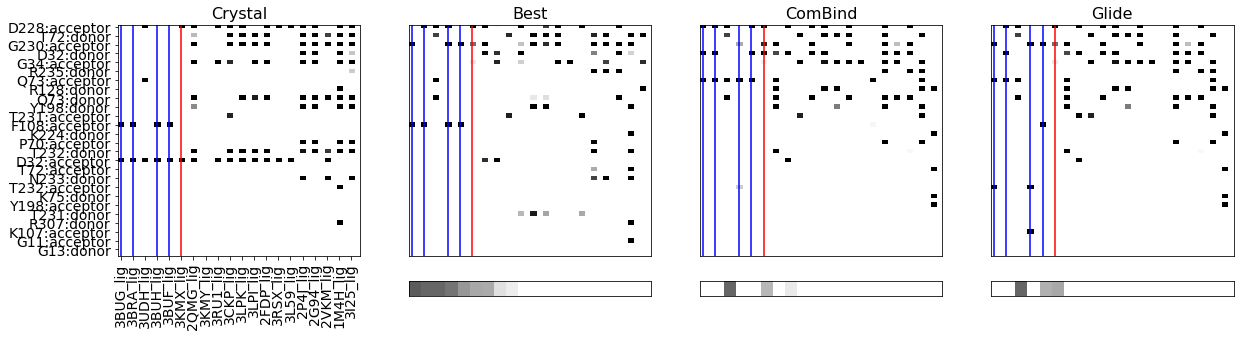

results BACE1/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/3I25_lig-to-1FKN.sc, BACE1, 1FKN, confgen_es4


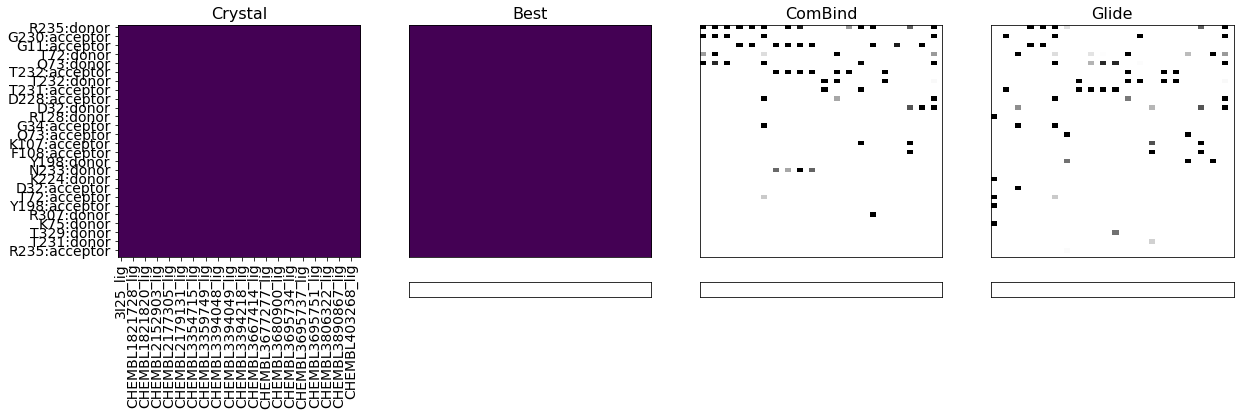

TRPV1
results TRPV1/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, TRPV1, 3J5Q, confgen_es4


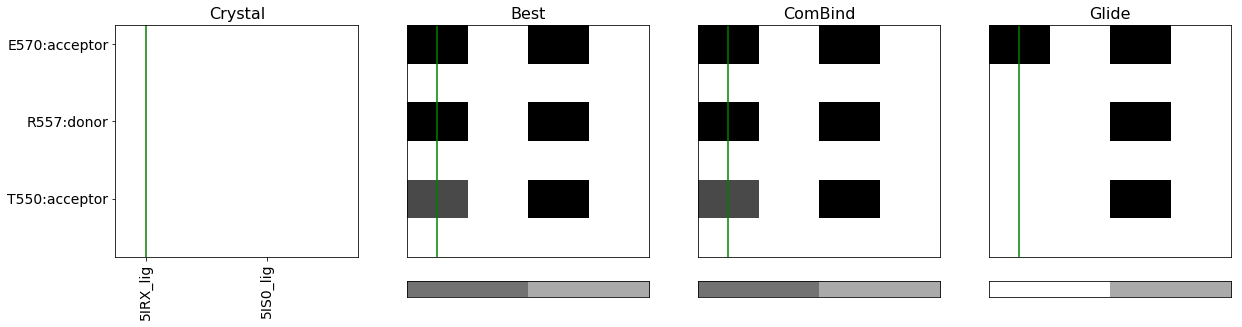

results TRPV1/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/5IS0_lig-to-3J5Q.sc, TRPV1, 3J5Q, confgen_es4


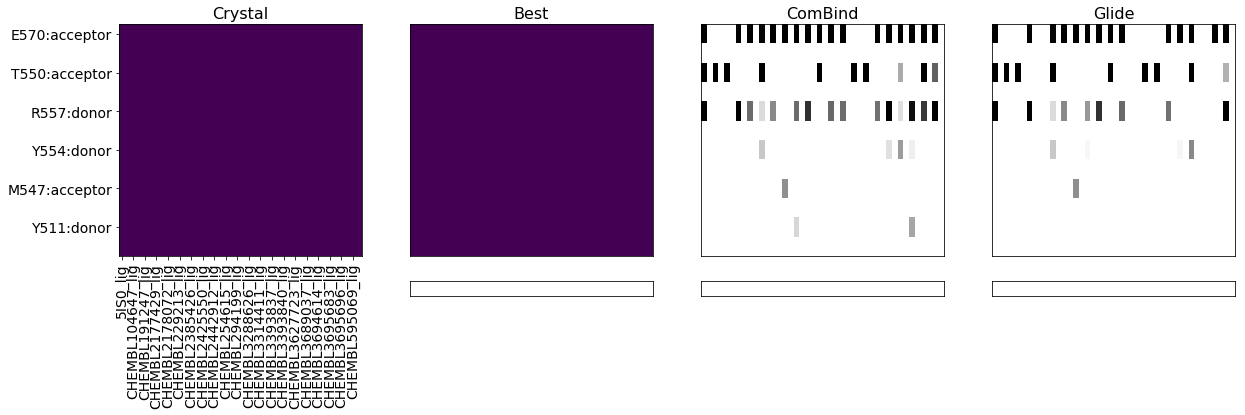

MEK1
results MEK1/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, MEK1, 1S9J, confgen_es4


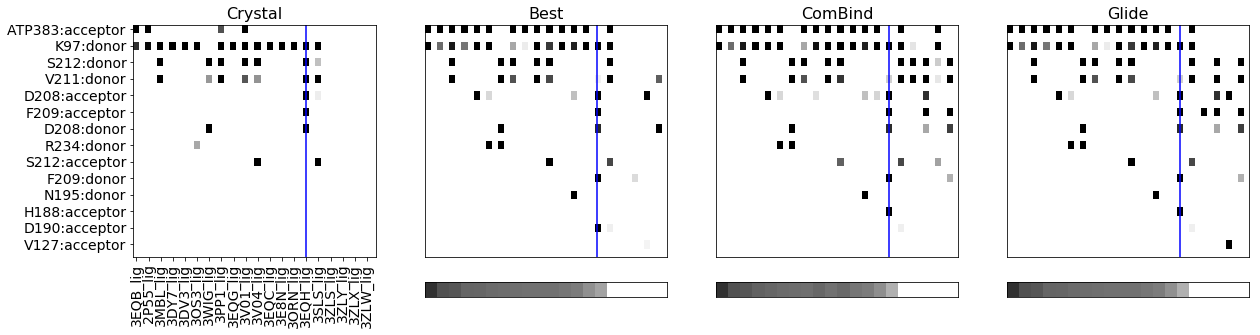

results MEK1/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/3V04_lig-to-1S9J.sc, MEK1, 1S9J, confgen_es4


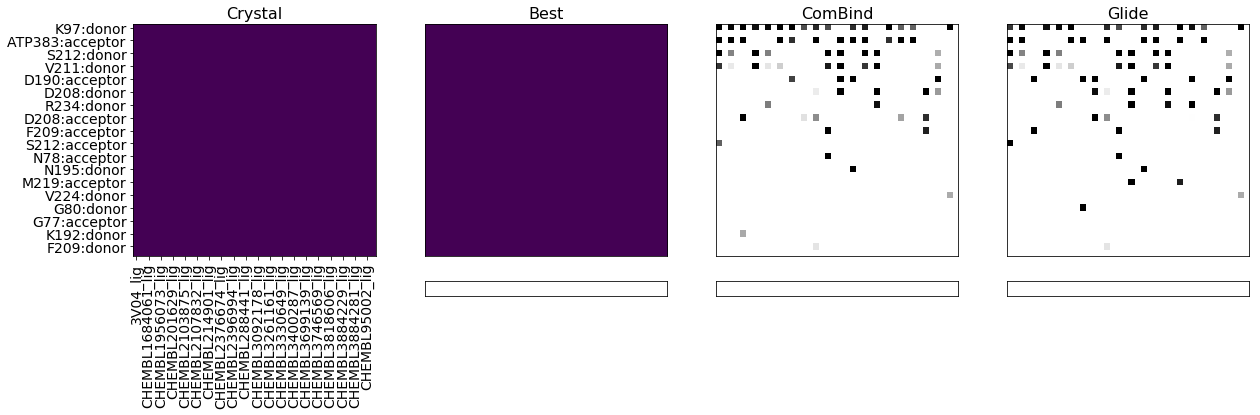

F10
results F10/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, F10, 1EZQ, confgen_es4


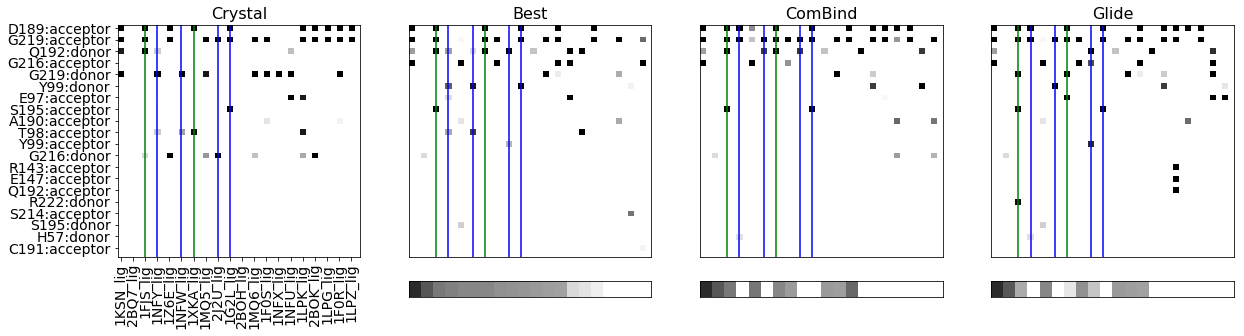

results F10/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/1LPK_lig-to-1EZQ.sc, F10, 1EZQ, confgen_es4


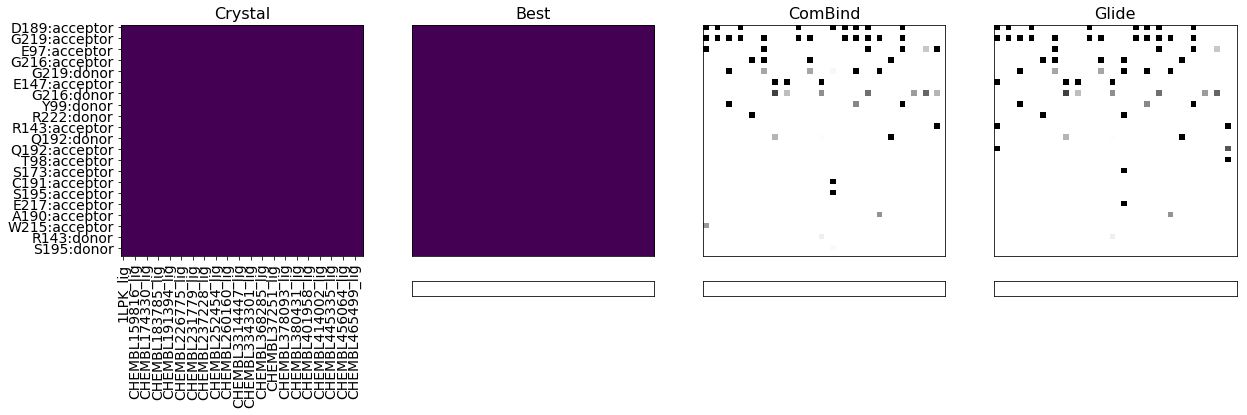

SIGMAR1
results SIGMAR1/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, SIGMAR1, 5HK1, confgen_es4


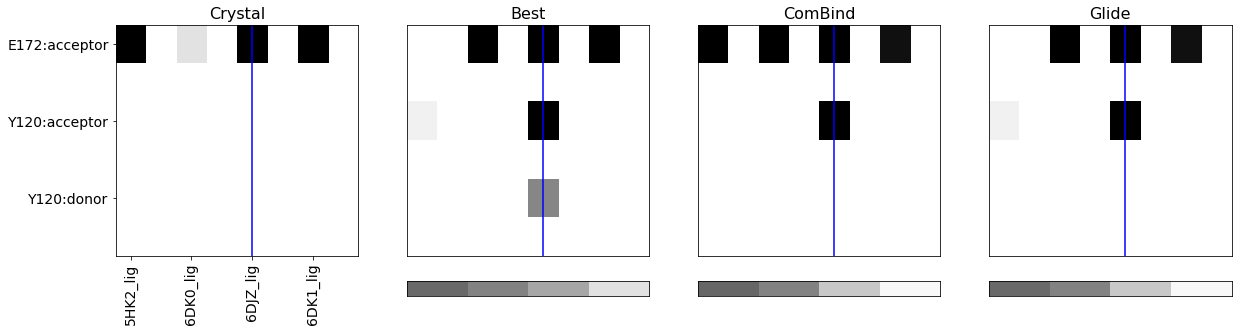

results SIGMAR1/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/6DK1_lig-to-5HK1.sc, SIGMAR1, 5HK1, confgen_es4


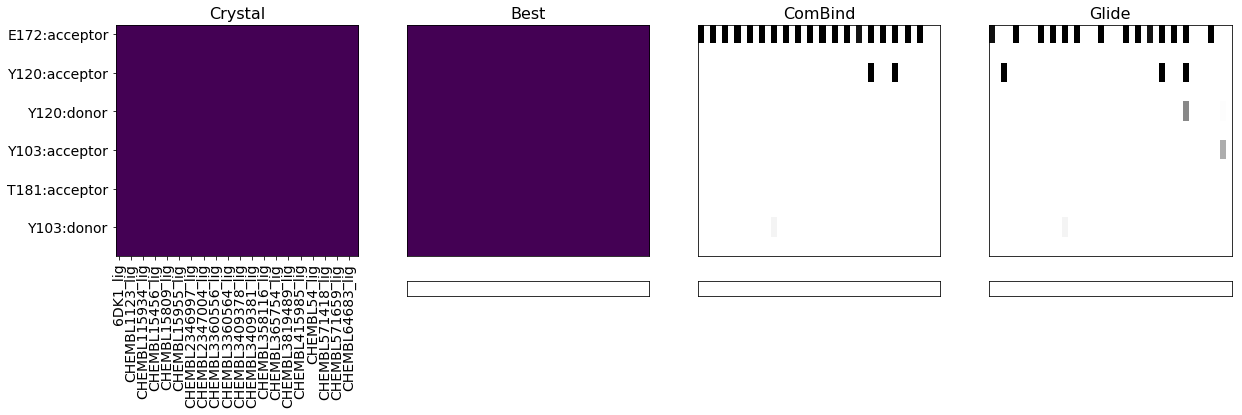

MGLUR5
results MGLUR5/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, MGLUR5, 4OO9, confgen_es4


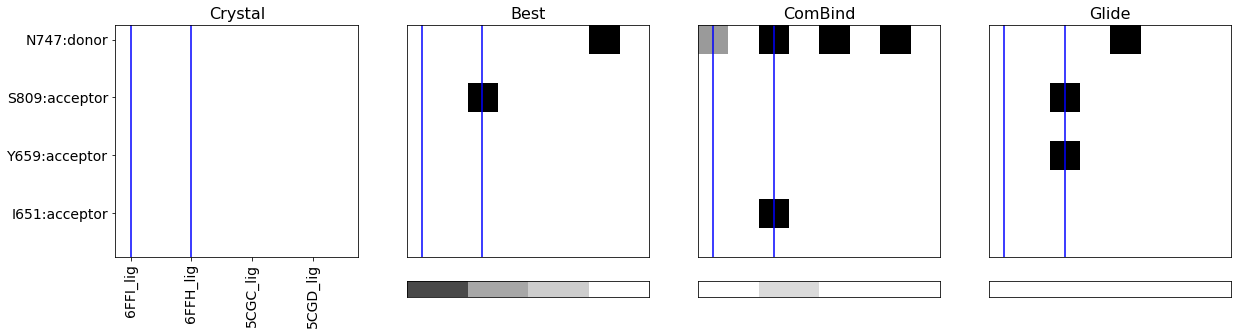

results MGLUR5/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/5CGC_lig-to-4OO9.sc, MGLUR5, 4OO9, confgen_es4


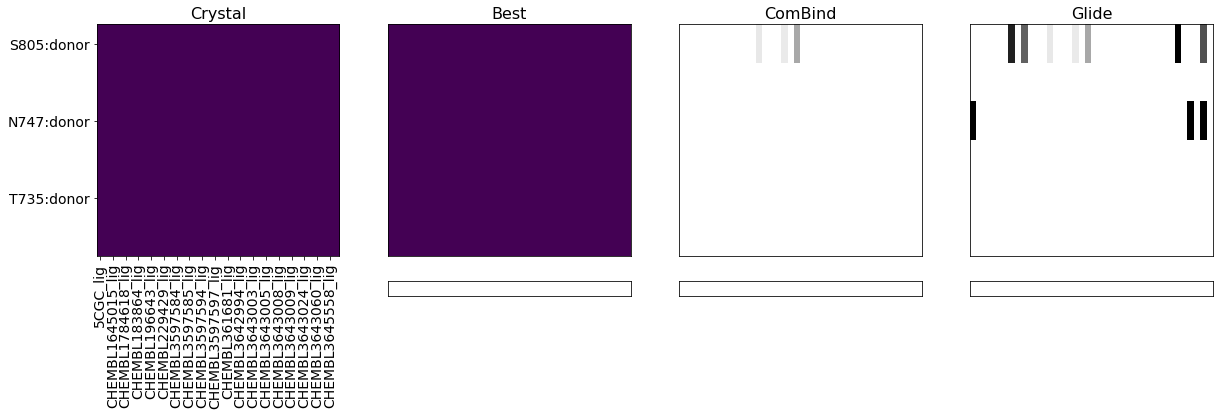

ELANE
results ELANE/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, ELANE, 3Q77, confgen_es4


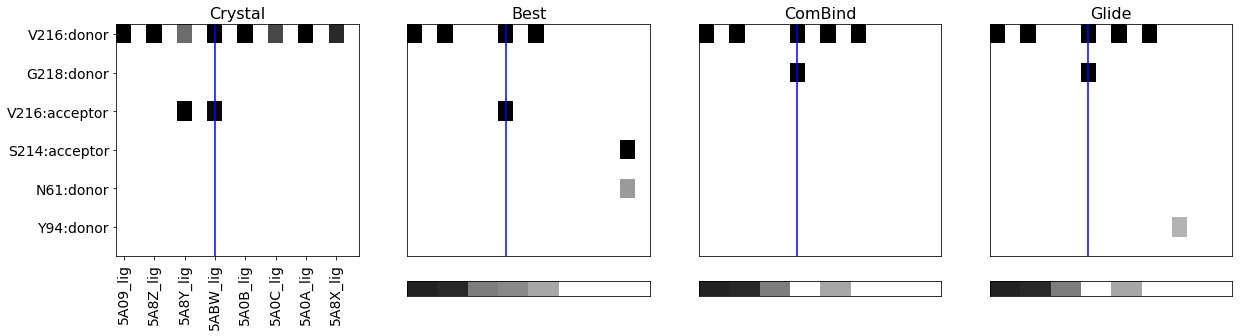

results ELANE/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/5A0A_lig-to-3Q77.sc, ELANE, 3Q77, confgen_es4


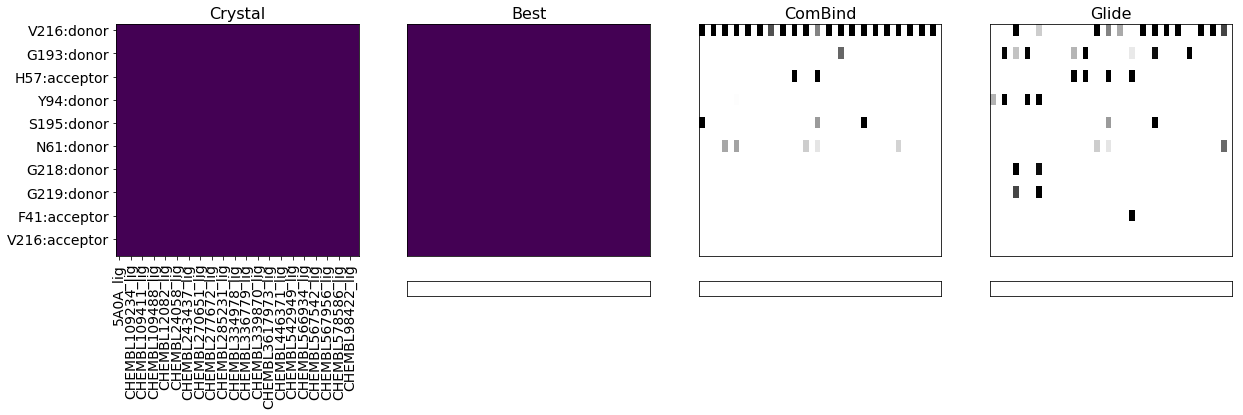

5HT2B
results 5HT2B/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, 5HT2B, 4IB4, confgen_es4


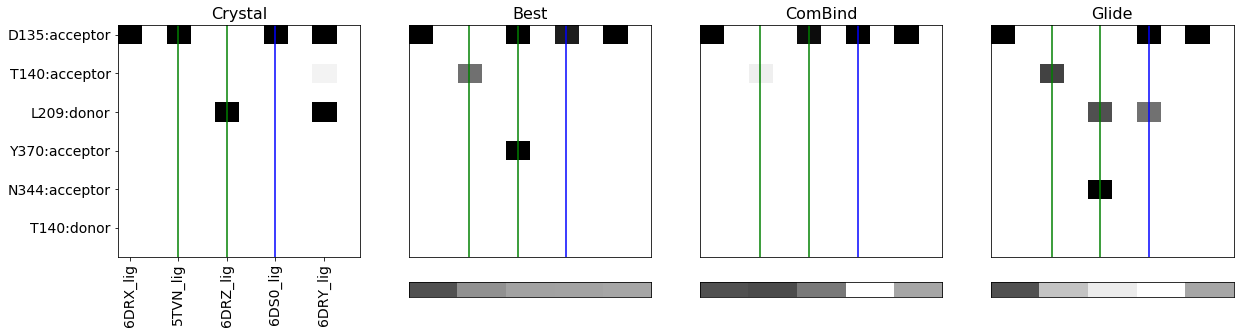

results 5HT2B/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/6DRX_lig-to-4IB4.sc, 5HT2B, 4IB4, confgen_es4


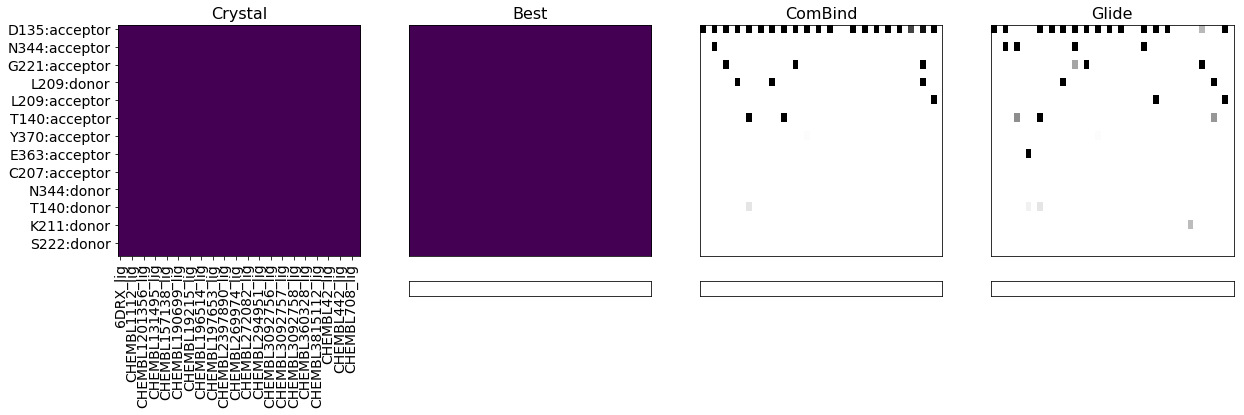

DHFR
results DHFR/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, DHFR, 1BOZ, confgen_es4
too many values to unpack (expected 3)
/Users/jpaggi/Downloads/combind_data/bpp_data/DHFR/ifp/ifp5/2W3A_struct.fp fp not found
too many values to unpack (expected 3)
/Users/jpaggi/Downloads/combind_data/bpp_data/DHFR/ifp/ifp5/4KAK_struct.fp fp not found


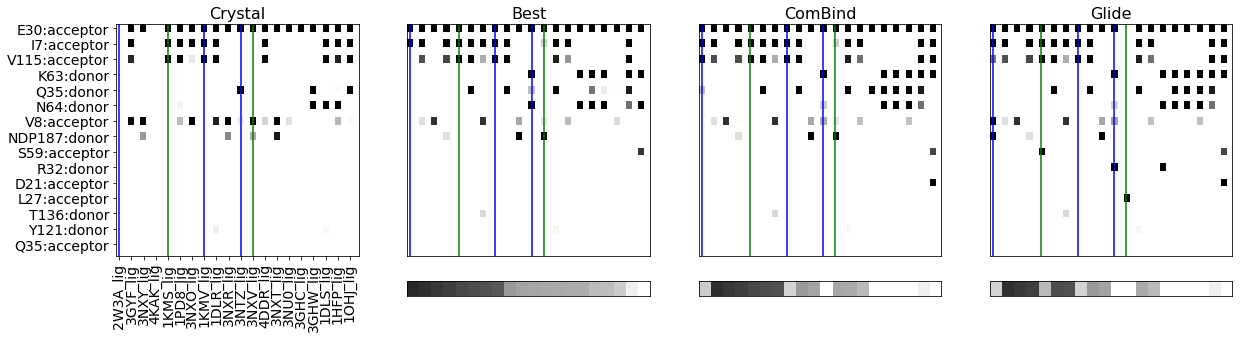

results DHFR/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/1HFP_lig-to-1BOZ.sc, DHFR, 1BOZ, confgen_es4


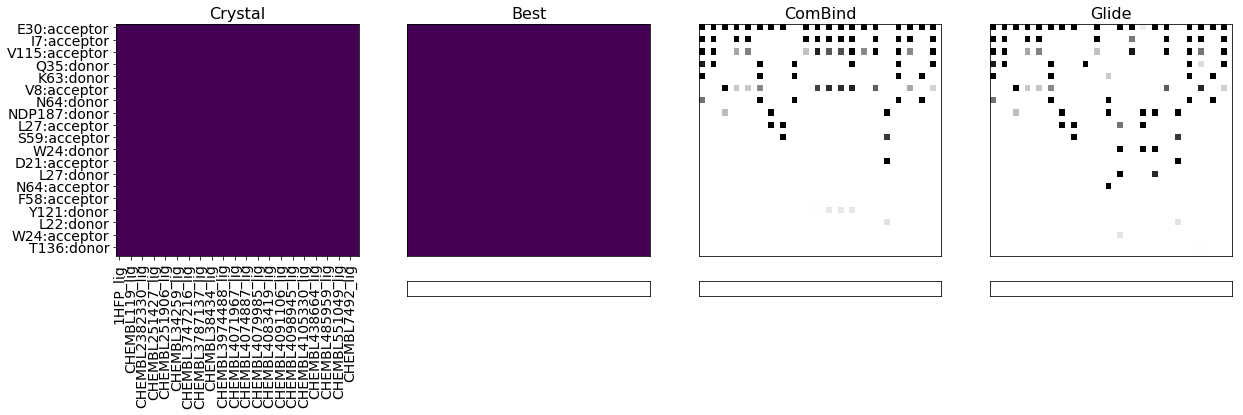

SMO
results SMO/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, SMO, 4JKV, confgen_es4


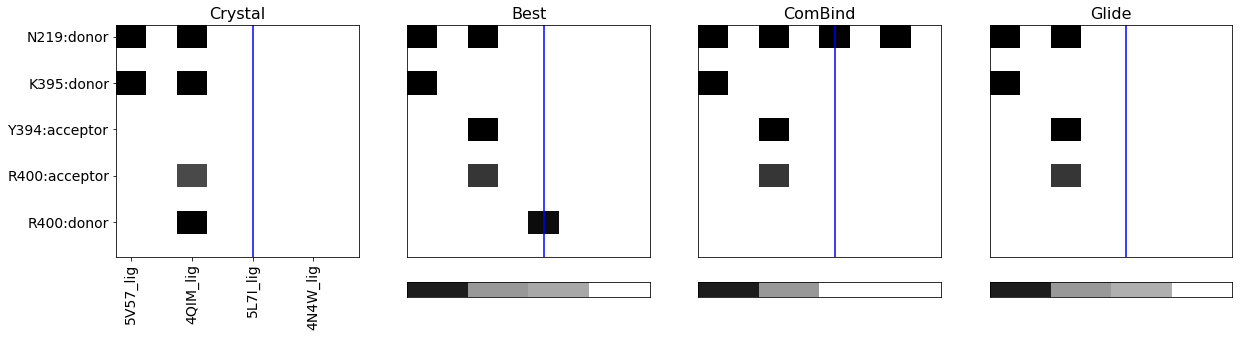

results SMO/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/4QIM_lig-to-4JKV.sc, SMO, 4JKV, confgen_es4


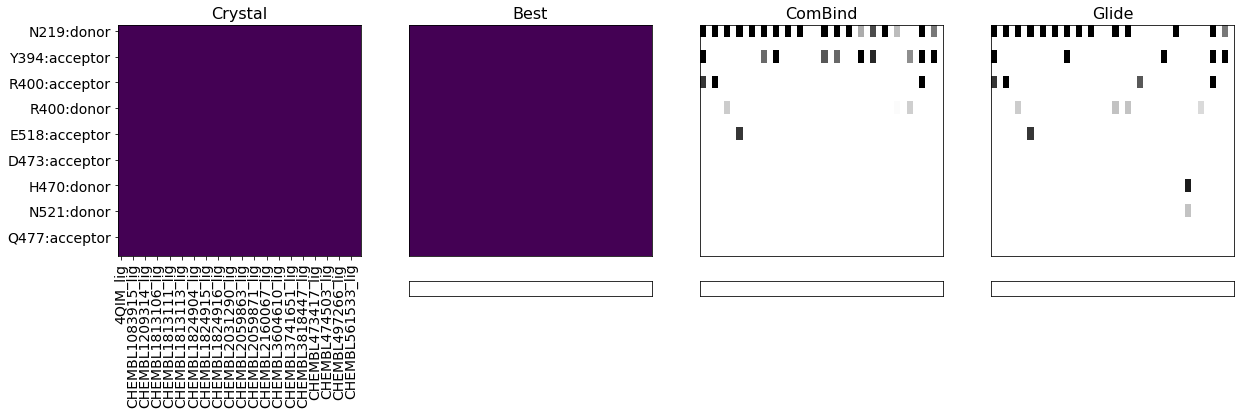

BRD4
results BRD4/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, BRD4, 2YEL, confgen_es4


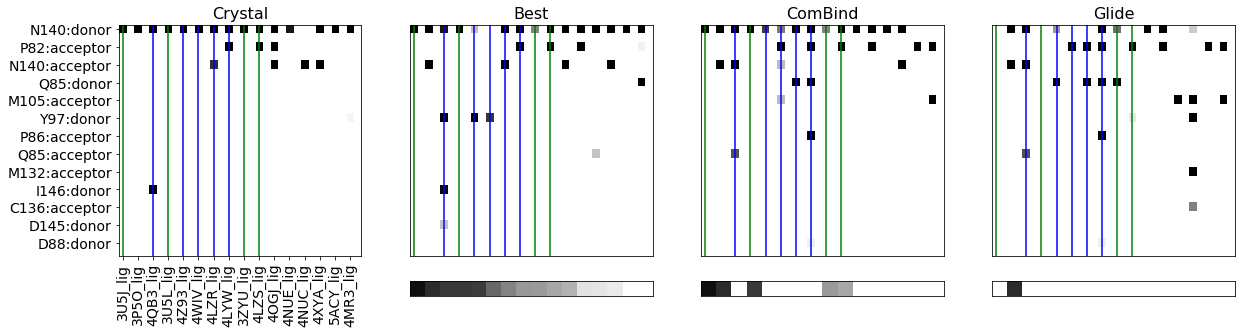

results BRD4/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/4MR3_lig-to-2YEL.sc, BRD4, 2YEL, confgen_es4


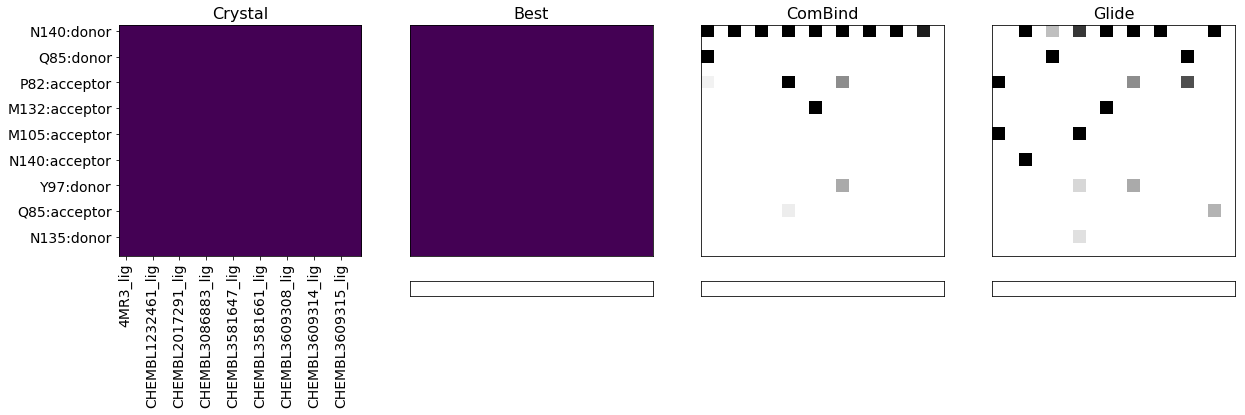

F11
results F11/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, F11, 4CR5, confgen_es4
too many values to unpack (expected 3)
/Users/jpaggi/Downloads/combind_data/bpp_data/F11/ifp/ifp5/4CR9_struct.fp fp not found


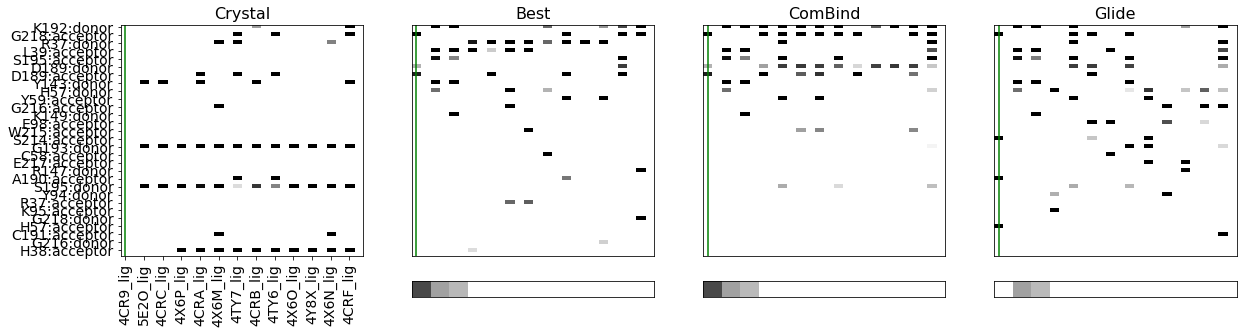

results F11/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/4TY7_lig-to-4CR5.sc, F11, 4CR5, confgen_es4


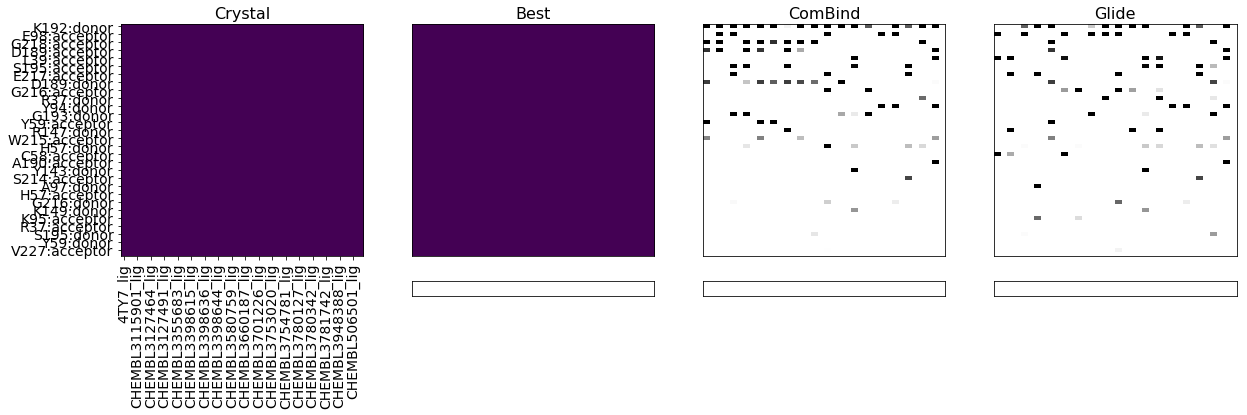

MAPK14
results MAPK14/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, MAPK14, 1KV1, confgen_es4


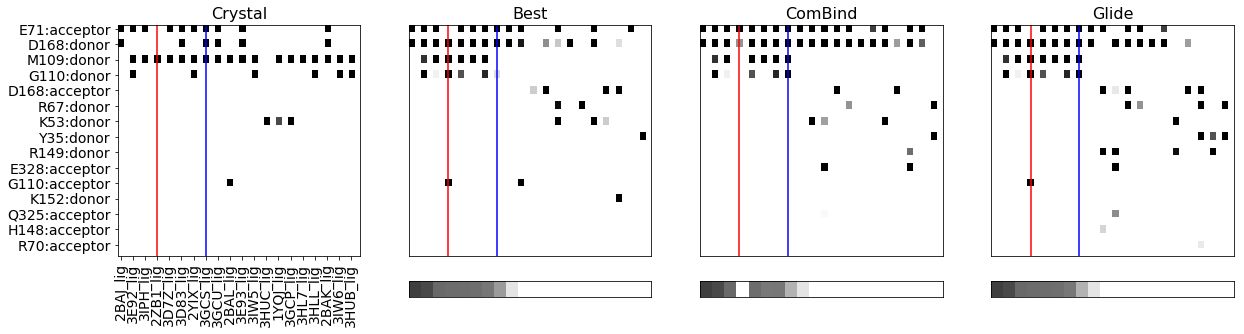

results MAPK14/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/3D7Z_lig-to-1KV1.sc, MAPK14, 1KV1, confgen_es4


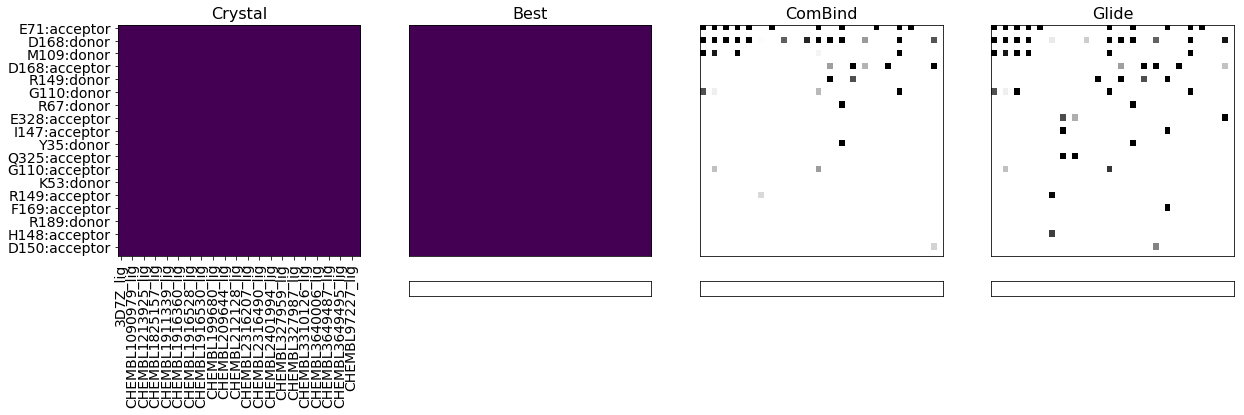

A2AR
results A2AR/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, A2AR, 2YDO, confgen_es4


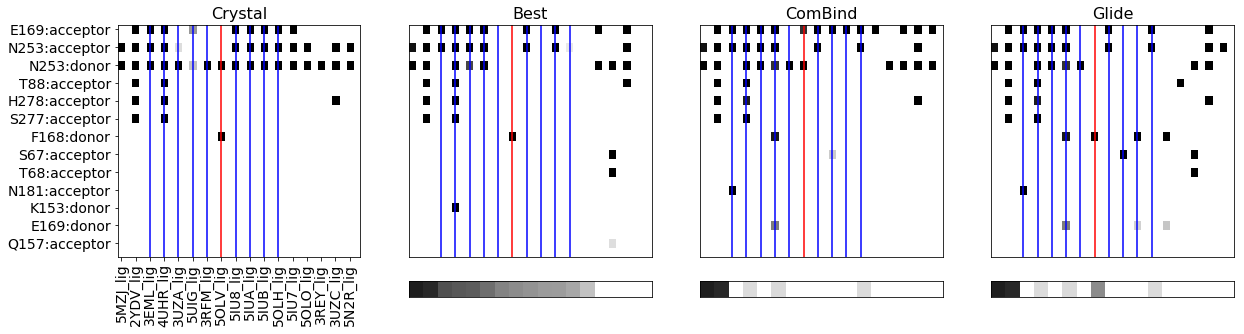

results A2AR/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/5IU7_lig-to-2YDO.sc, A2AR, 2YDO, confgen_es4


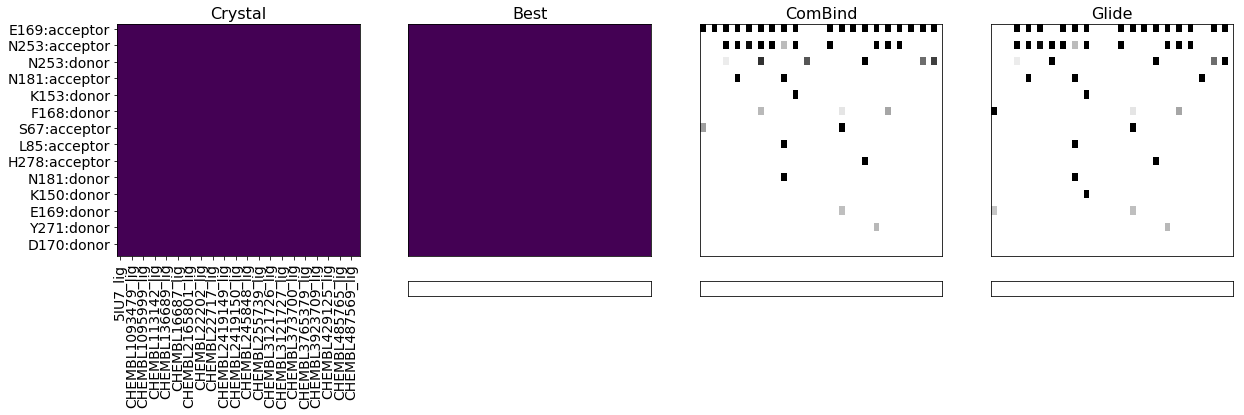

P00760
results P00760/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, P00760, 1BJU, confgen_es4


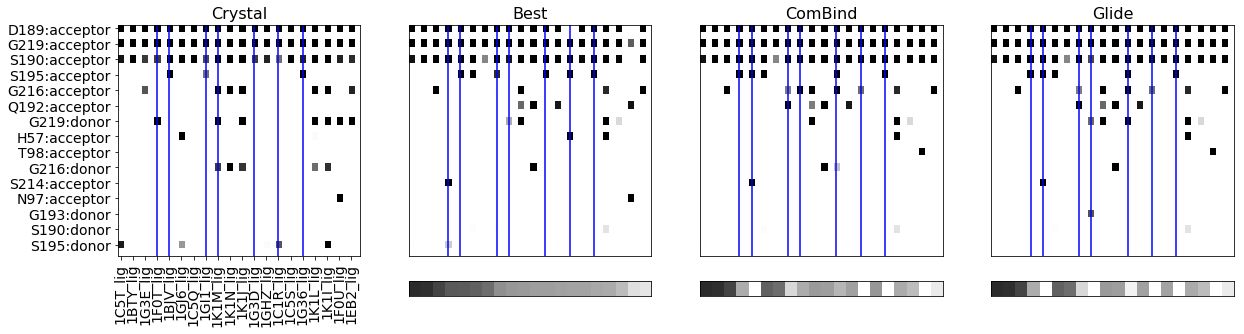

results P00760/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/1K1J_lig-to-1BJU.sc, P00760, 1BJU, confgen_es4


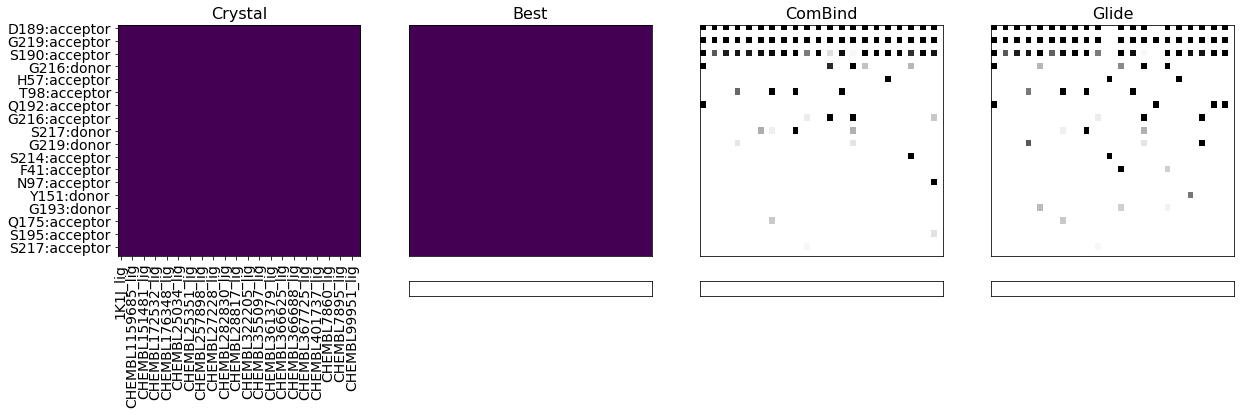

CDK2
results CDK2/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, CDK2, 1AQ1, confgen_es4
too many values to unpack (expected 3)
/Users/jpaggi/Downloads/combind_data/bpp_data/CDK2/ifp/ifp5/1FIN_struct.fp fp not found


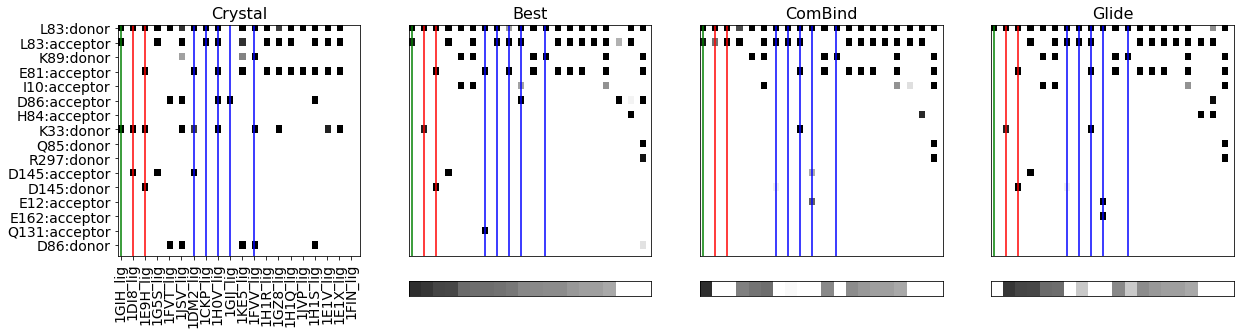

results CDK2/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/1G5S_lig-to-1AQ1.sc, CDK2, 1AQ1, confgen_es4


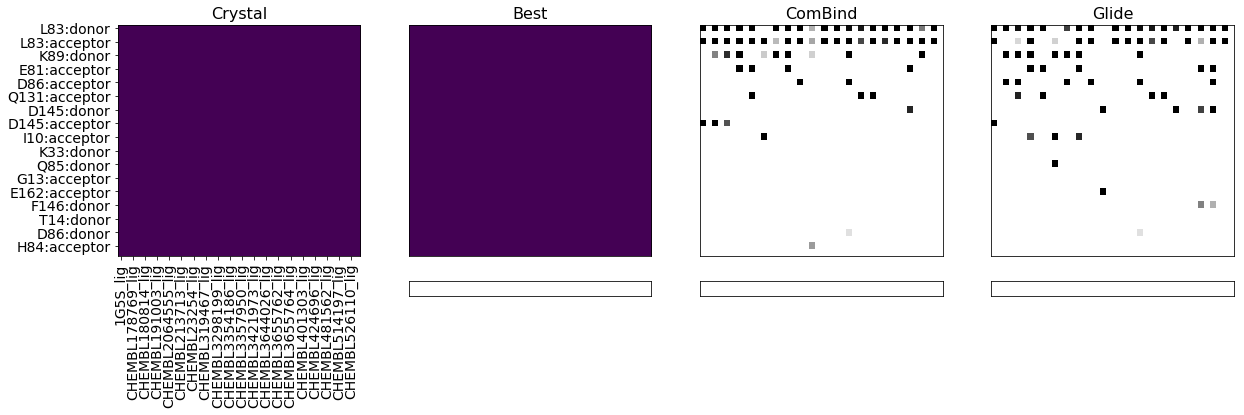

NR3C2
results NR3C2/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, NR3C2, 3WFF, confgen_es4


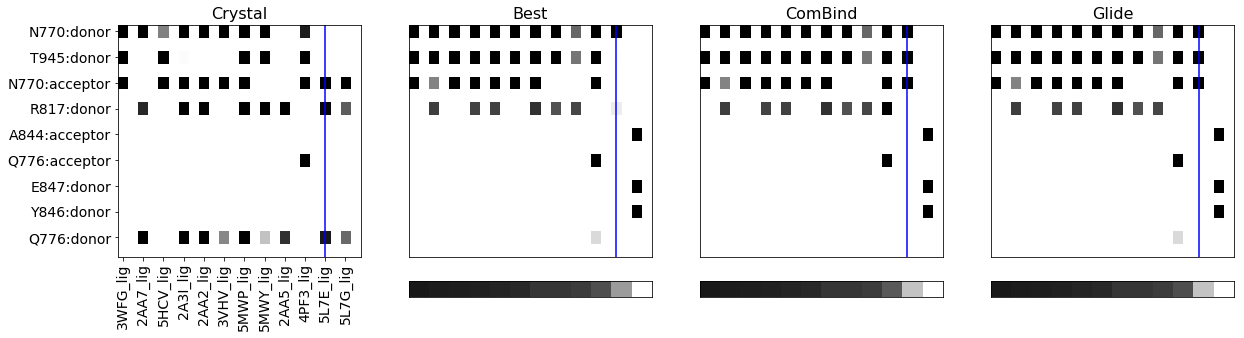

results NR3C2/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/5MWP_lig-to-3WFF.sc, NR3C2, 3WFF, confgen_es4


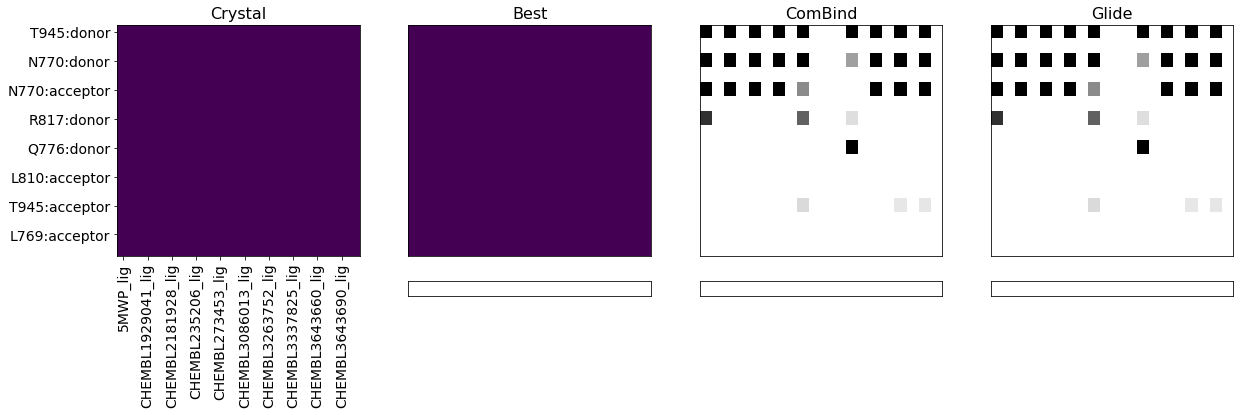

JAK2
results JAK2/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, JAK2, 2B7A, confgen_es4


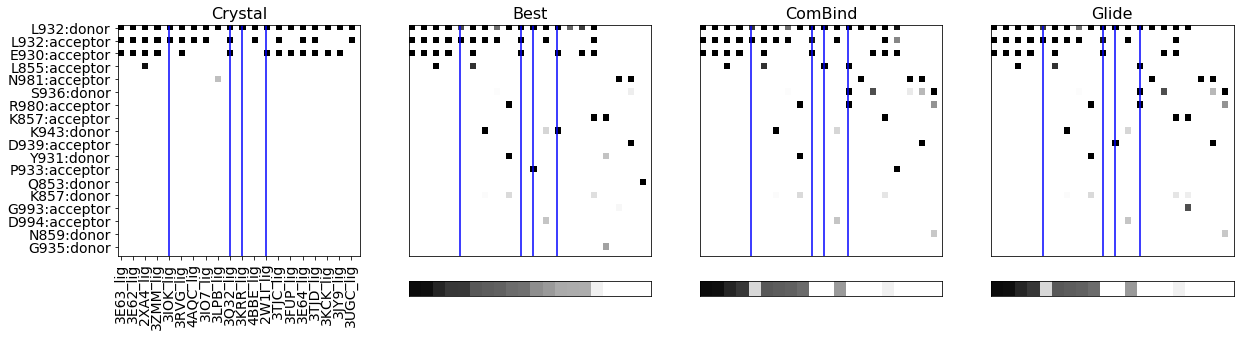

results JAK2/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/3E63_lig-to-2B7A.sc, JAK2, 2B7A, confgen_es4


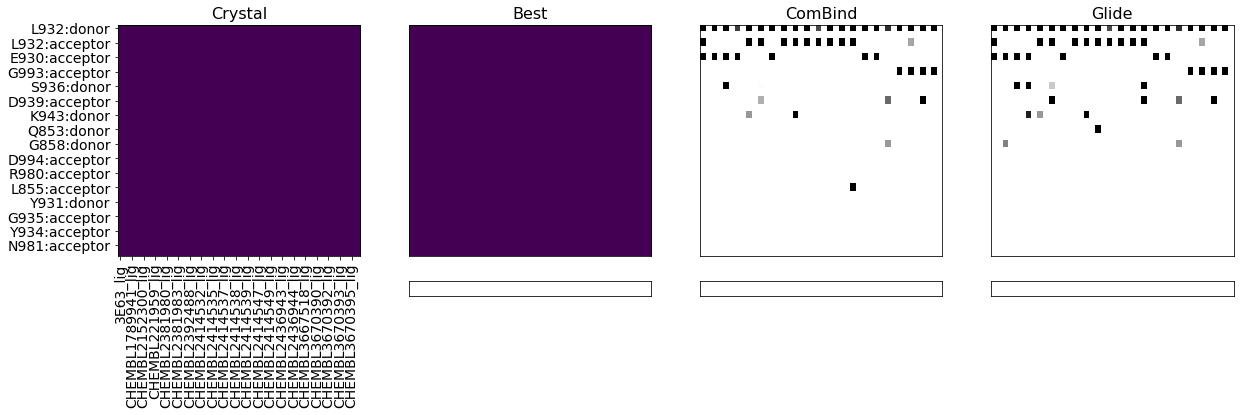

CHK1
results CHK1/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, CHK1, 1NVQ, confgen_es4


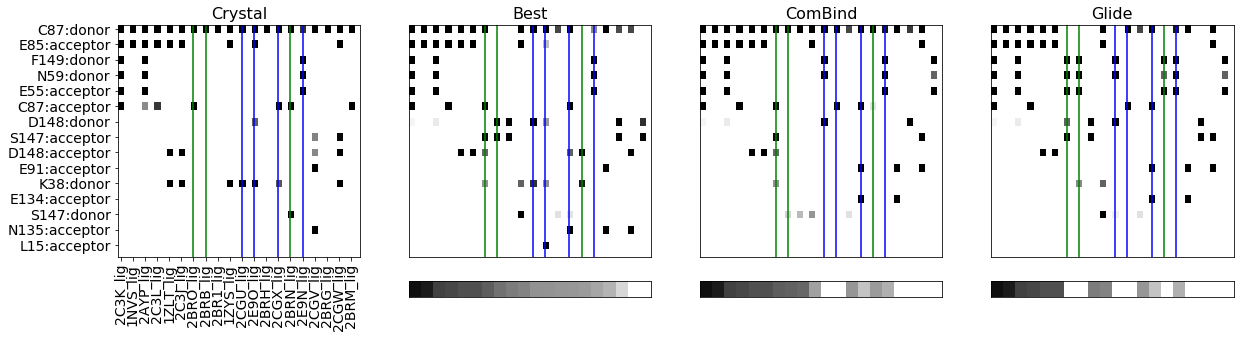

results CHK1/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/2CGU_lig-to-1NVQ.sc, CHK1, 1NVQ, confgen_es4


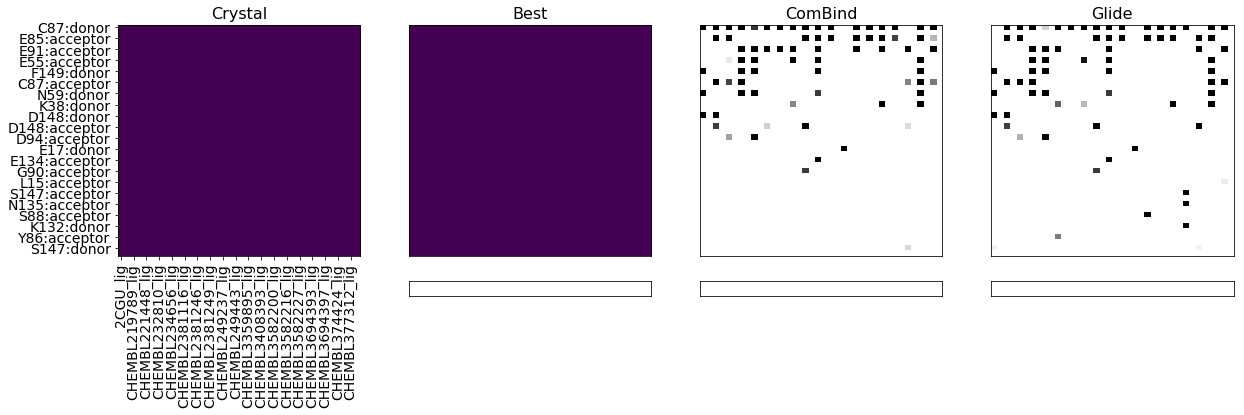

GLUT1
results GLUT1/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, GLUT1, 5EQG, confgen_es4


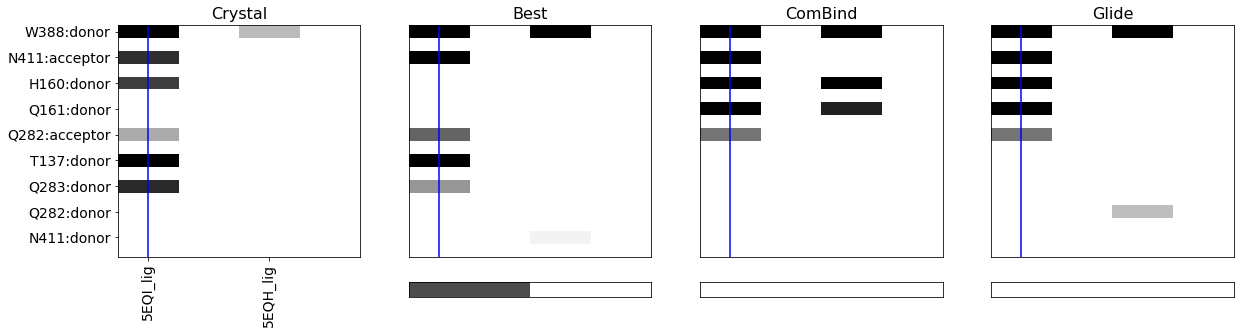

results GLUT1/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/5EQH_lig-to-5EQG.sc, GLUT1, 5EQG, confgen_es4


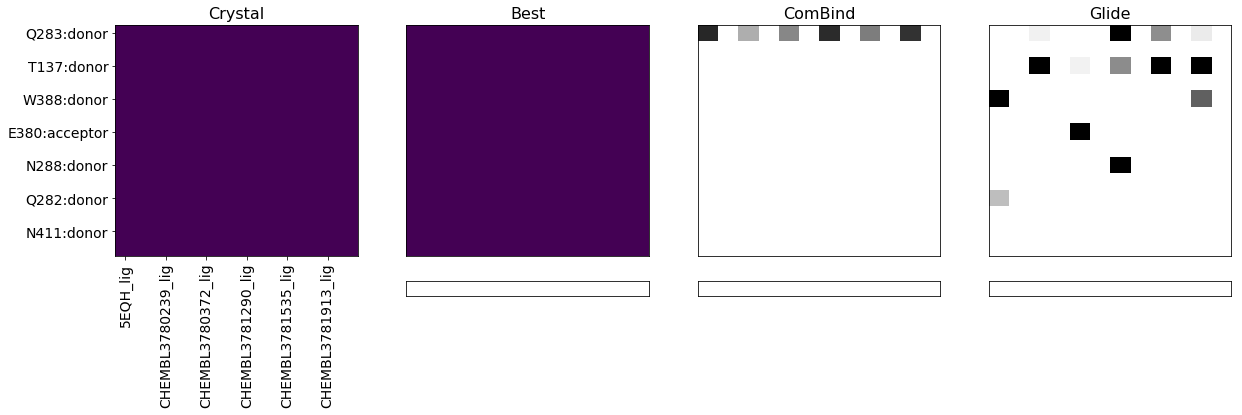

VDR
results VDR/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, VDR, 1DB1, confgen_es4


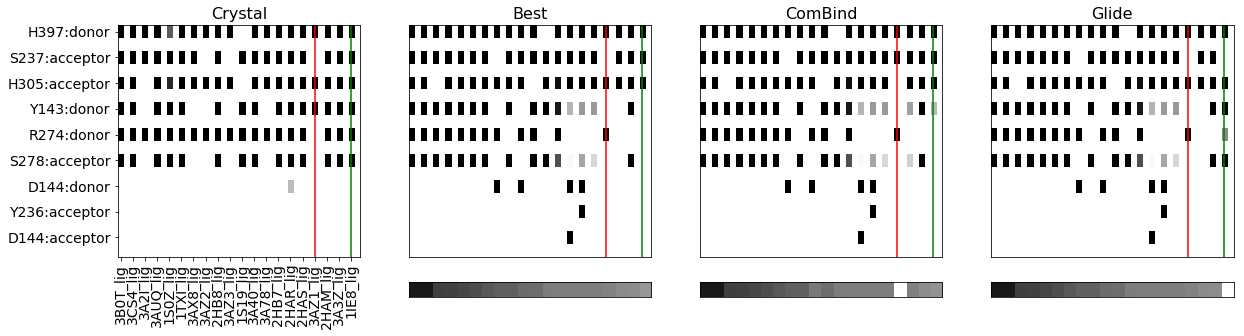

results VDR/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/3AUQ_lig-to-1DB1.sc, VDR, 1DB1, confgen_es4


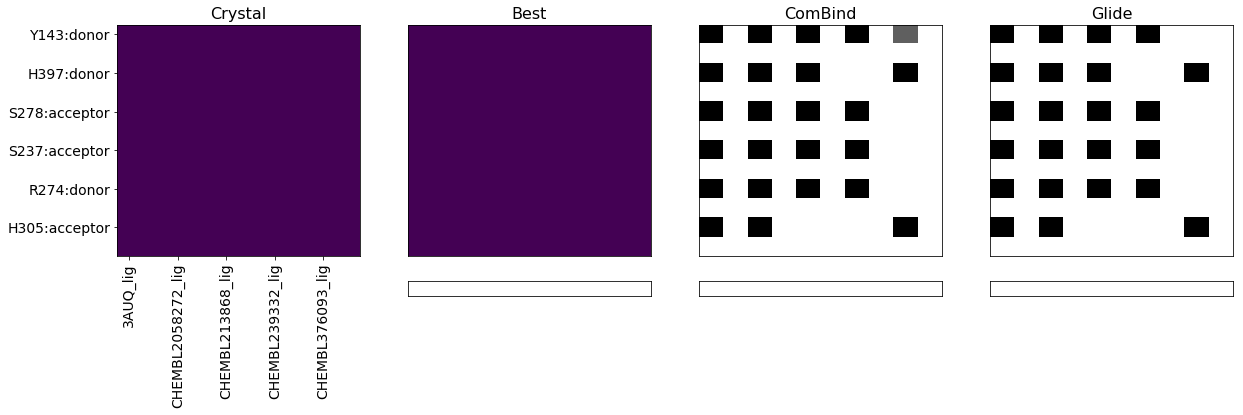

PDE10A
results PDE10A/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, PDE10A, 3UI7, confgen_es4
too many values to unpack (expected 3)
/Users/jpaggi/Downloads/combind_data/bpp_data/PDE10A/ifp/ifp5/4HF4_struct.fp fp not found


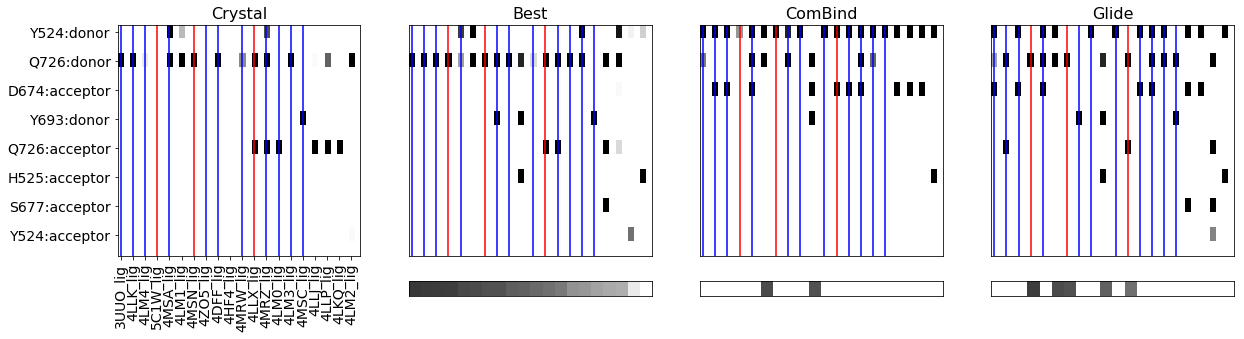

results PDE10A/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/4LKQ_lig-to-3UI7.sc, PDE10A, 3UI7, confgen_es4


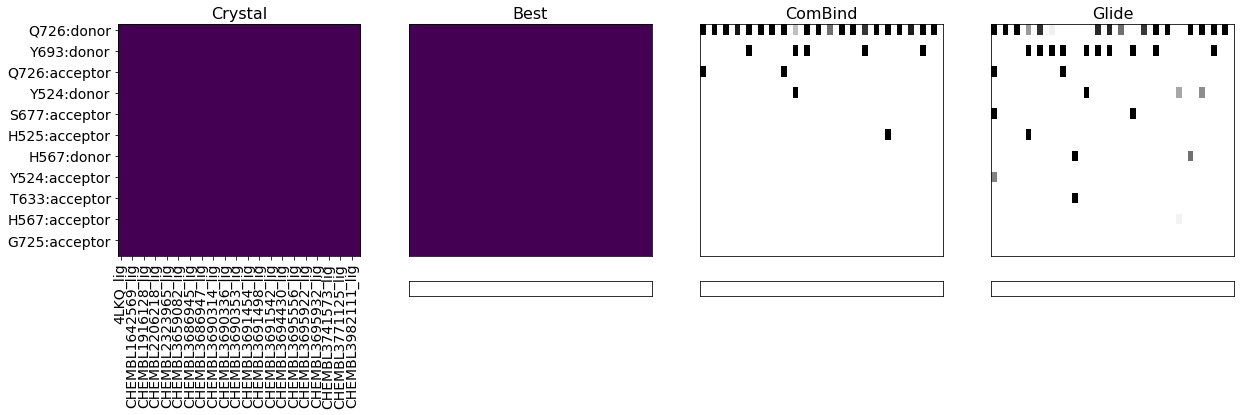

PYGM
results PYGM/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, PYGM, 1A8I, confgen_es4
too many values to unpack (expected 3)
/Users/jpaggi/Downloads/combind_data/bpp_data/PYGM/ifp/ifp5/2G9Q_struct.fp fp not found
too many values to unpack (expected 3)
/Users/jpaggi/Downloads/combind_data/bpp_data/PYGM/ifp/ifp5/2QRH_struct.fp fp not found
too many values to unpack (expected 3)
/Users/jpaggi/Downloads/combind_data/bpp_data/PYGM/ifp/ifp5/3G2I_struct.fp fp not found


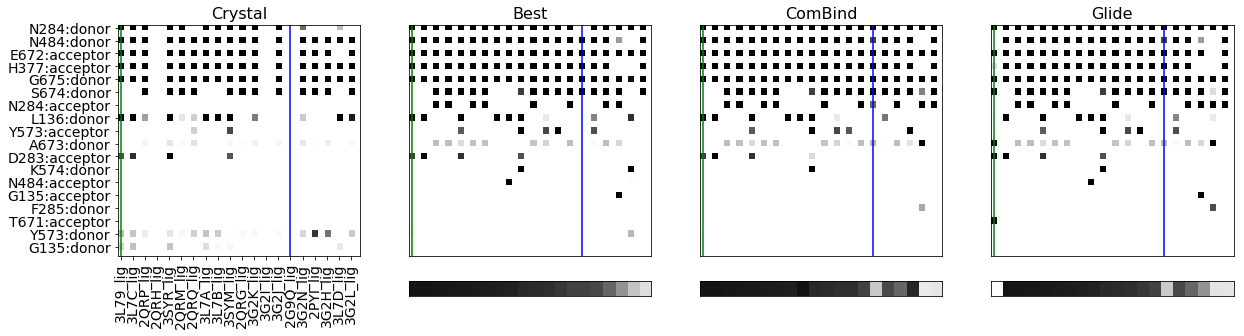

results PYGM/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/3G2K_lig-to-1A8I.sc, PYGM, 1A8I, confgen_es4


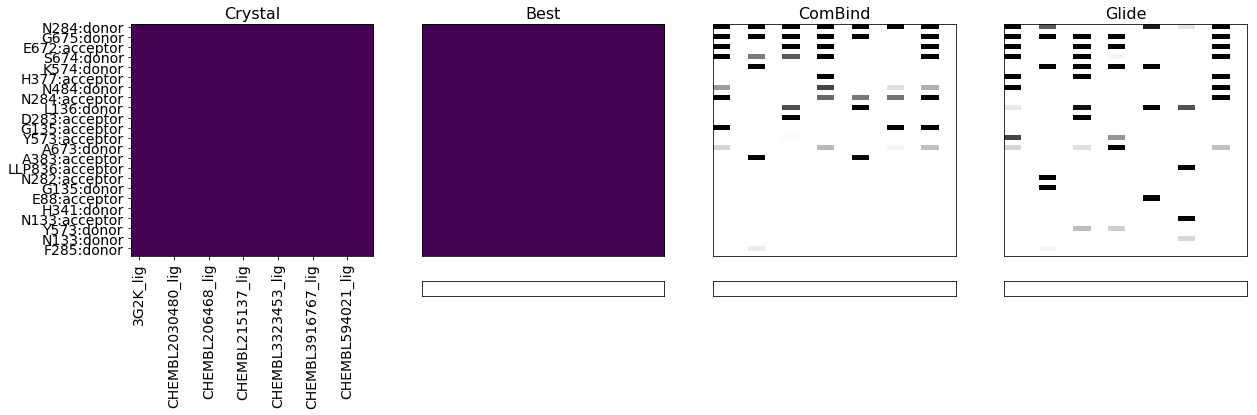

NR3C1
results NR3C1/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, NR3C1, 3BQD, confgen_es4
too many values to unpack (expected 3)
/Users/jpaggi/Downloads/combind_data/bpp_data/NR3C1/ifp/ifp5/4P6X_struct.fp fp not found


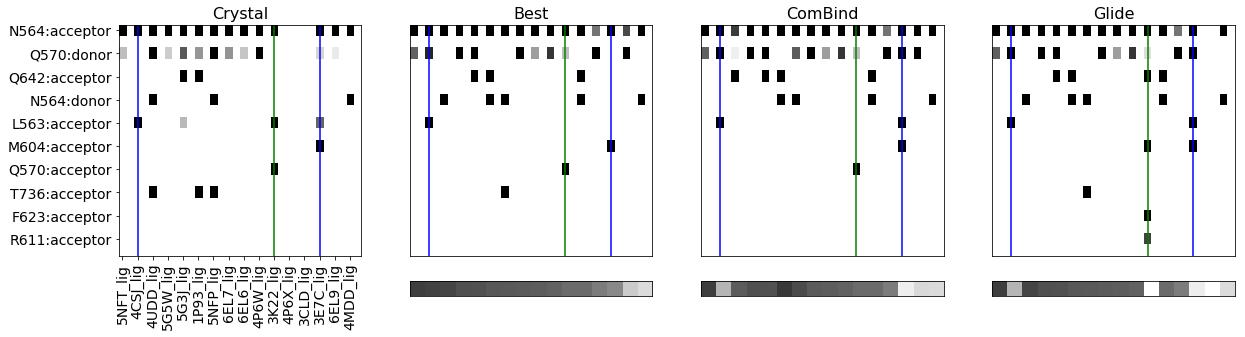

results NR3C1/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/6EL6_lig-to-3BQD.sc, NR3C1, 3BQD, confgen_es4


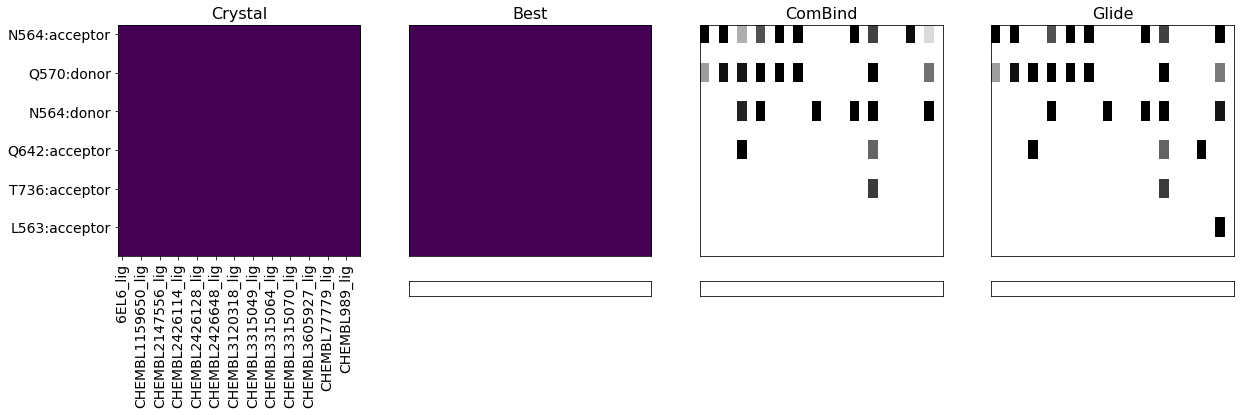

BRAF
results BRAF/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, BRAF, 1UWH, confgen_es4


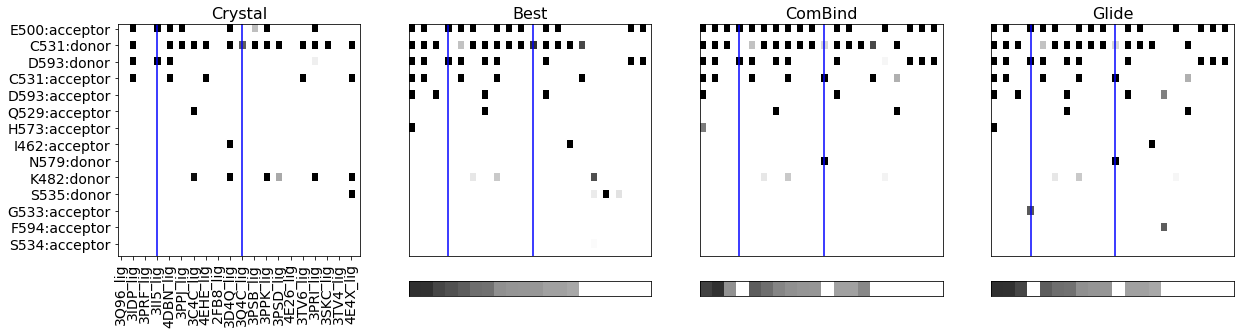

results BRAF/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/3PSB_lig-to-1UWH.sc, BRAF, 1UWH, confgen_es4


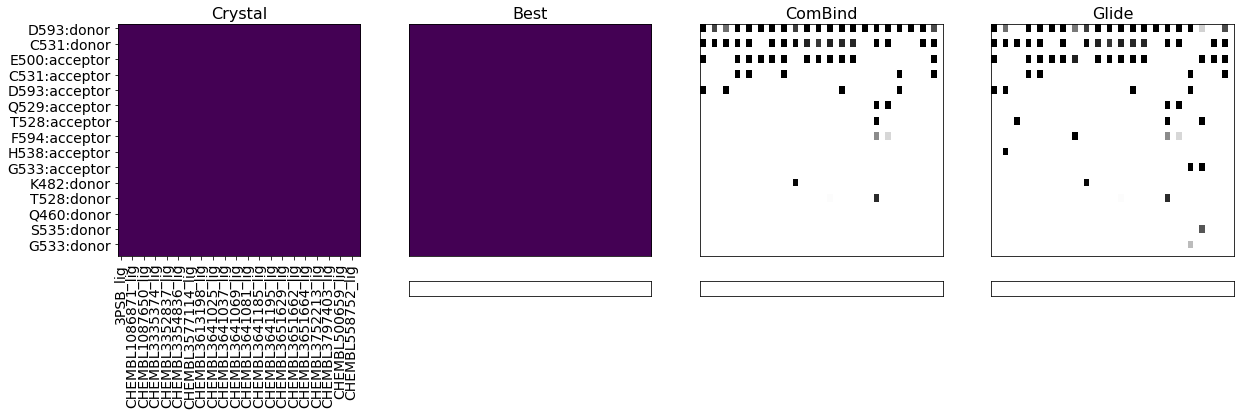

SLC6A4
results SLC6A4/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, SLC6A4, 5I6X, confgen_es4


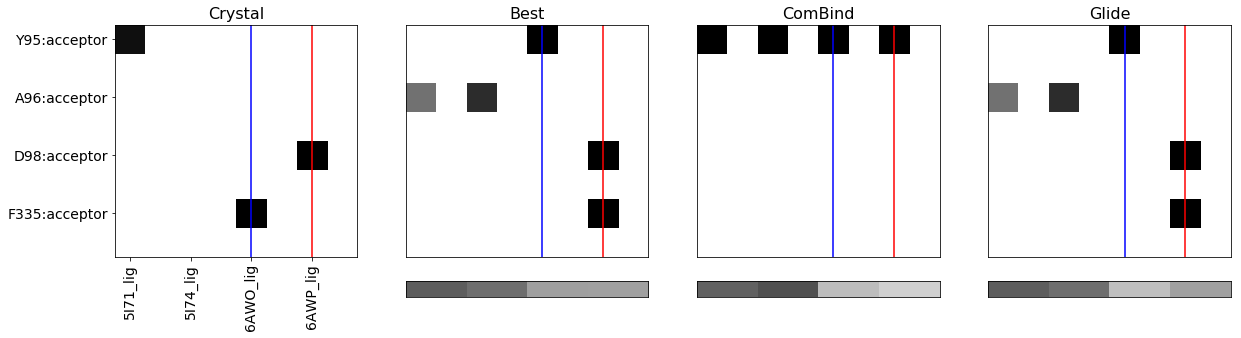

results SLC6A4/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/5I74_lig-to-5I6X.sc, SLC6A4, 5I6X, confgen_es4


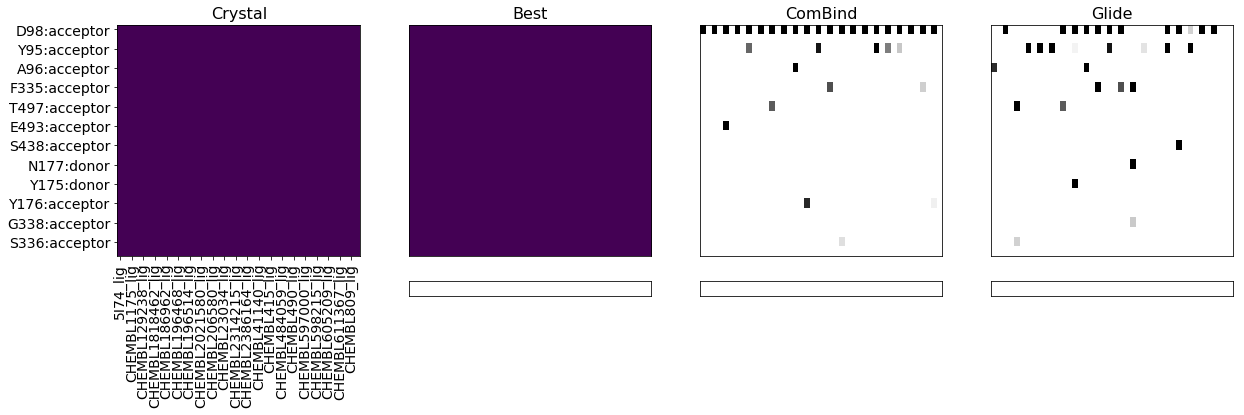

F2
results F2/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, F2, 1A4W, confgen_es4


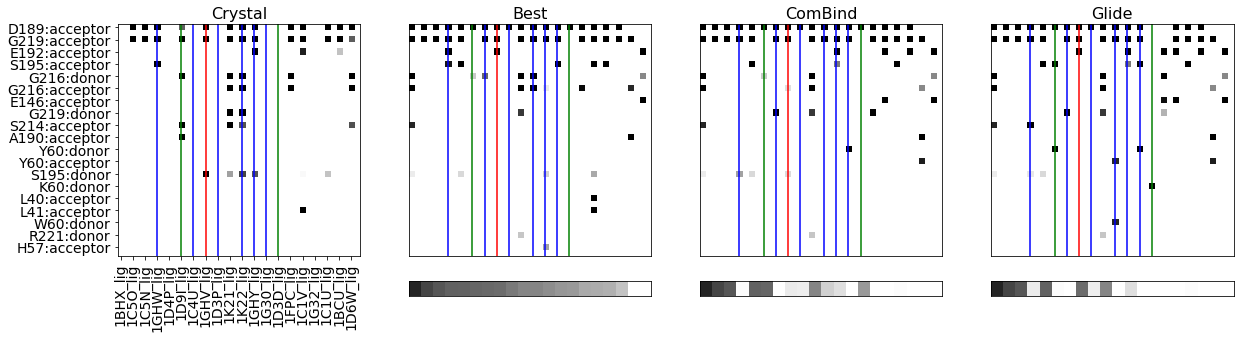

results F2/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/1C1U_lig-to-1A4W.sc, F2, 1A4W, confgen_es4


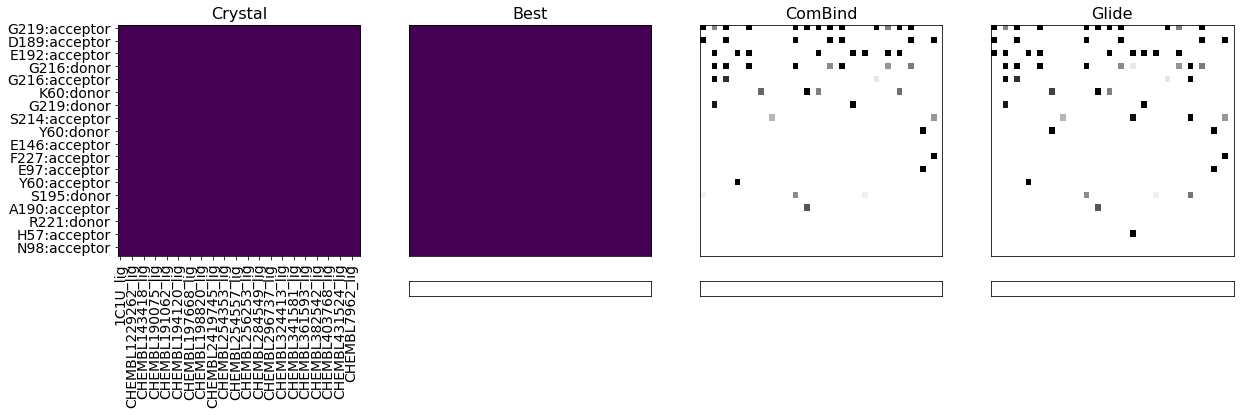

AR
results AR/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, AR, 2AXA, confgen_es4


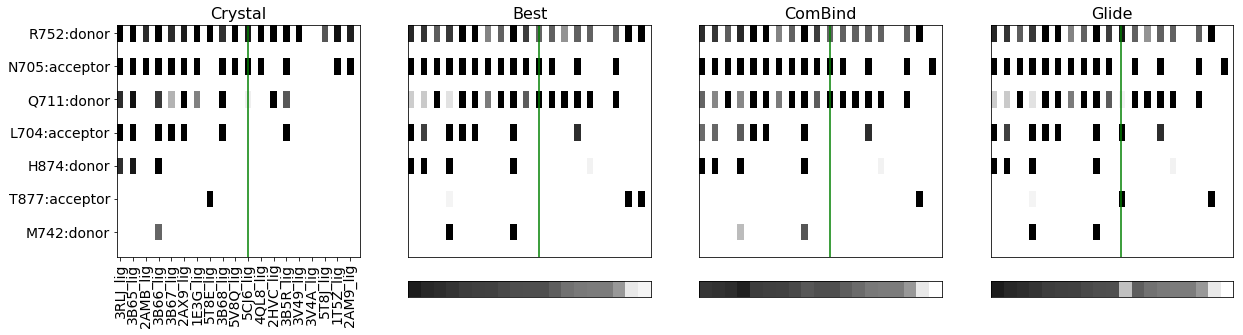

results AR/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/4QL8_lig-to-2AXA.sc, AR, 2AXA, confgen_es4


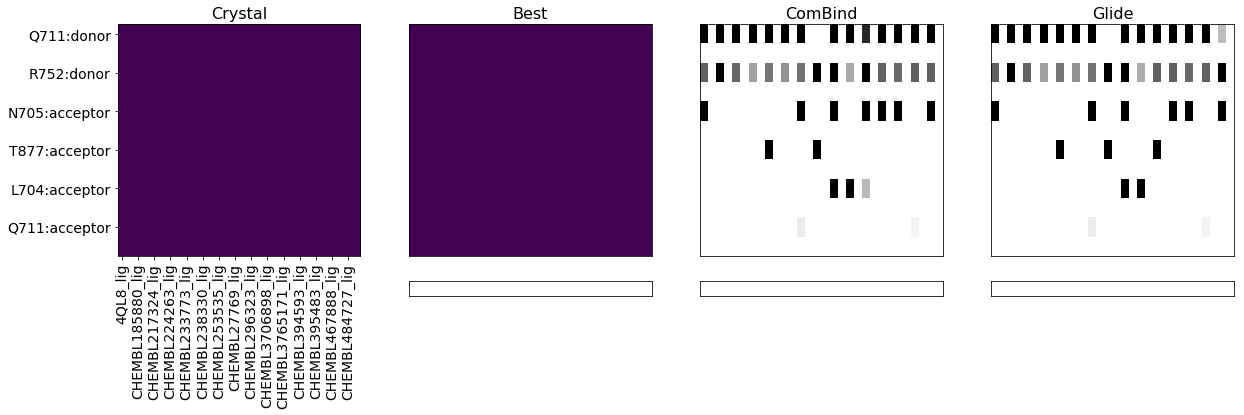

ERA
results ERA/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, ERA, 1A52, confgen_es4
too many values to unpack (expected 3)
/Users/jpaggi/Downloads/combind_data/bpp_data/ERA/ifp/ifp5/1XQC_struct.fp fp not found


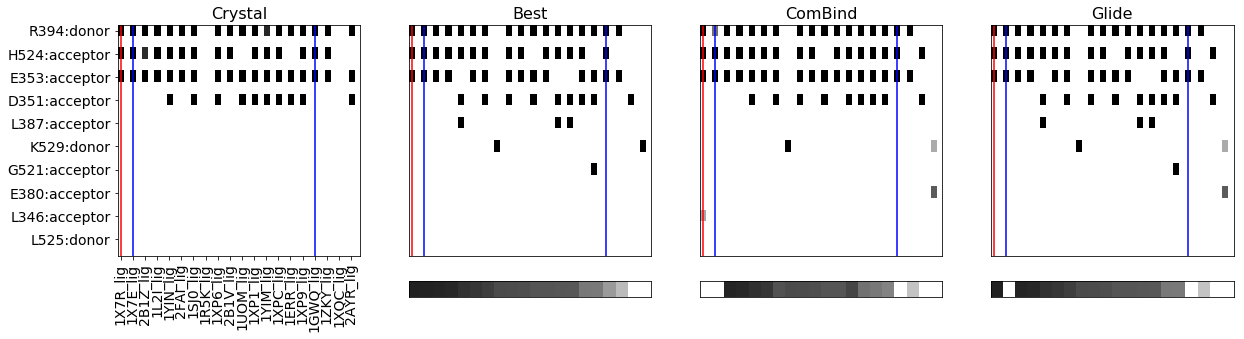

results ERA/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/1YIM_lig-to-1A52.sc, ERA, 1A52, confgen_es4


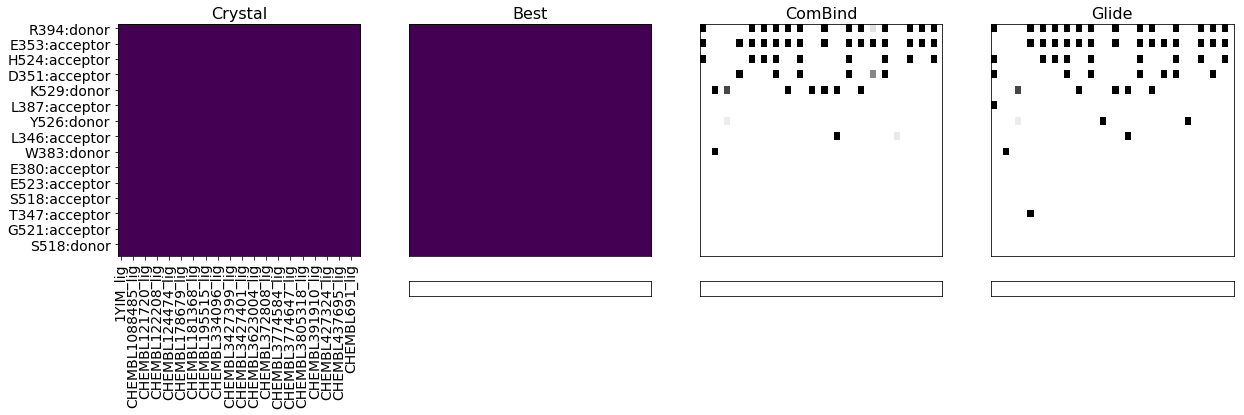

PLK1
results PLK1/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, PLK1, 2OWB, confgen_es4


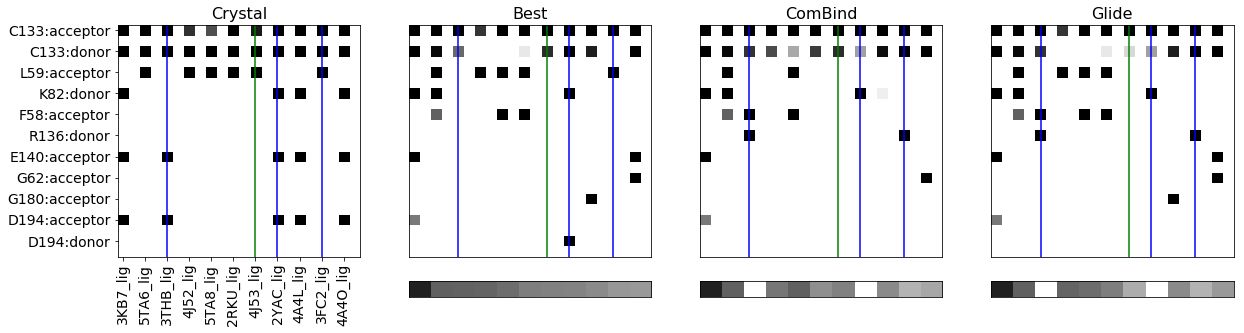

results PLK1/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/4J52_lig-to-2OWB.sc, PLK1, 2OWB, confgen_es4


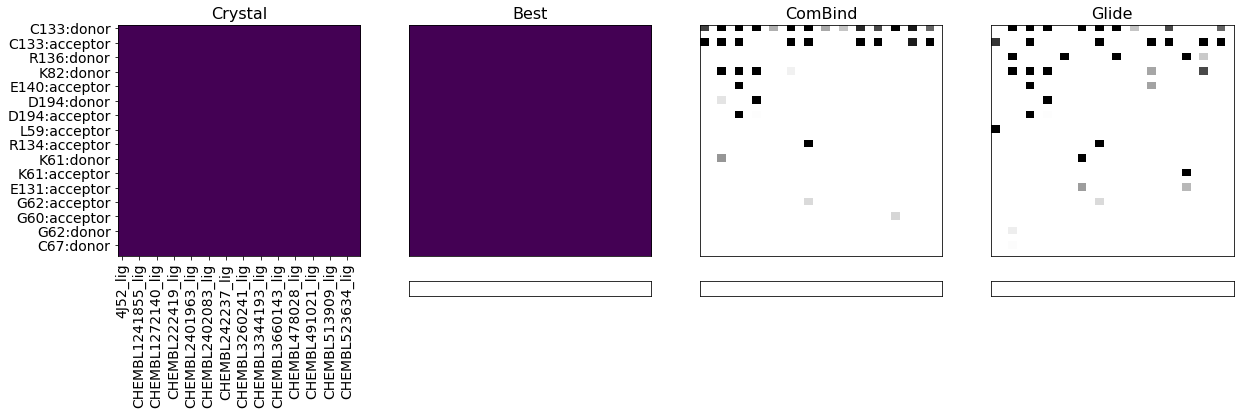

HSP90AA1
results HSP90AA1/scores/stats21/pdb/standard/1.0-mcss_hbond_sb/pdb.sc, HSP90AA1, 1YC1, confgen_es4
too many values to unpack (expected 3)
/Users/jpaggi/Downloads/combind_data/bpp_data/HSP90AA1/ifp/ifp5/2XDL_struct.fp fp not found


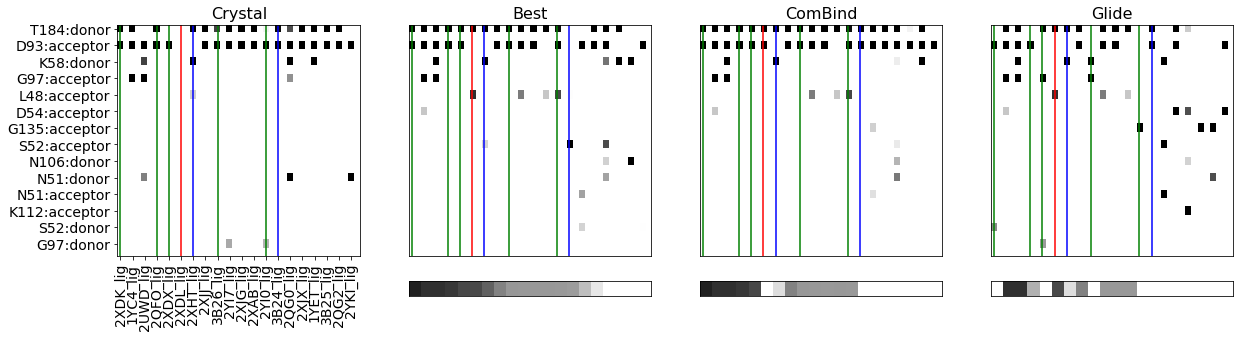

results HSP90AA1/scores/stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb/2XDX_lig-to-1YC1.sc, HSP90AA1, 1YC1, confgen_es4


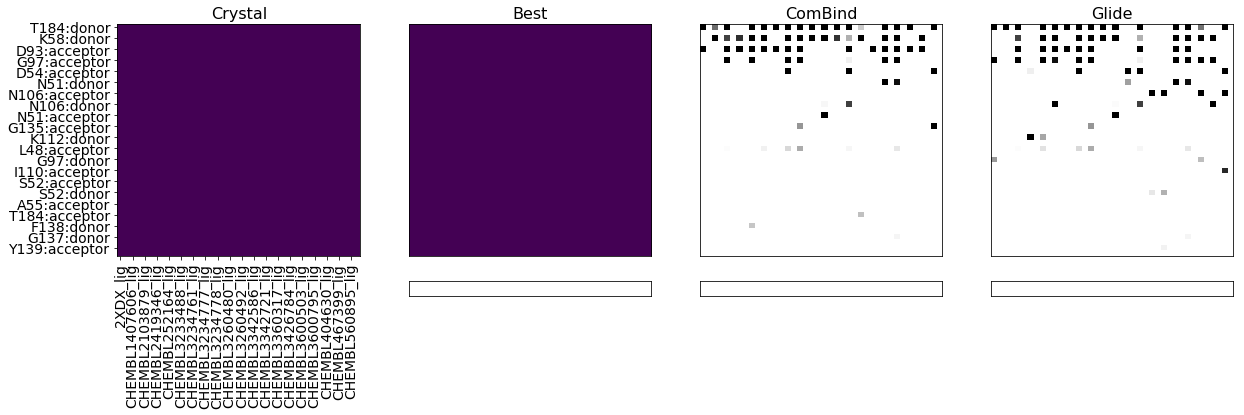

In [3]:
data = '/Users/jpaggi/Downloads/combind_data/bpp_data'
stats = 'stats21/stats'
pdb = 'stats21/pdb/standard/1.0-mcss_hbond_sb'
chembl = 'stats21/best_affinity_diverse/standard/20-1.0-mcss_contact_hbond_sb'

for prot in glob('{}/*'.format(data)):
    prot = prot.split('/')[-1]
    if prot in ['D2', 'CHRM3']: continue
    print(prot)
    struct = Protein(prot).lm.st
    pdb_fname = 'pdb.sc'
    print('results {0}/scores/{1}/{2}, {0}, {3}, confgen_es4'.format(prot, pdb, pdb_fname, struct))
    cluster, glide_cluster, best_cluster, sc = load(prot, stats, pdb, pdb_fname, struct)

    crystal = {}
    for name, _ligand in sc.ps.ligands.items():
        ligand = Ligand('', '', '', '')
        ligand.ligand = _ligand.ligand
        ligand.glide_path = _ligand.glide_path
        ligand.fp_path = _ligand.fp_path
        ligand.crystal_fp_path = _ligand.crystal_fp_path.replace('lig', 'struct')
        ligand.load_crystal_pose()
        crystal[name] = ligand

    crystal_ps = PredictStructs(crystal, None, {'native': {'hbond'},'reference': {'hbond'}}, ['hbond'], 100, 1)
    crystal_cluster = {lig:0 for lig in crystal}
    plot()

    chembl_fname = glob('{}/{}/scores/{}/*.sc'.format(data, prot, chembl))[0]
    chembl_fname = chembl_fname.split('/')[-1]
    print('results {0}/scores/{1}/{2}, {0}, {3}, confgen_es4'.format(prot, chembl, chembl_fname, struct))
    cluster, glide_cluster, best_cluster, sc = load(prot, stats, chembl, chembl_fname, struct)
    plot(False)